# **Full pipeline for DeepLabV3+ (ResNet101) + DenseCRF evaluation**

# *Solar Cell Defect Segmentation Project - Comprehensive Documentation*



## Table of Contents
1. [Project Overview](#project-overview)
2. [Dataset Structure & Characteristics](#dataset-structure)
3. [Data Preprocessing Pipeline](#data-preprocessing)
4. [Model Architecture](#model-architecture)
5. [Training Strategy](#training-strategy)
6. [Post-Processing with DenseCRF](#densecrf)
7. [Evaluation Metrics](#evaluation-metrics)
8. [Results & Analysis](#results)
9. [Technical Implementation Details](#technical-details)

---

## 1. Project Overview {#project-overview}

### **Problem Statement**
Detect and segment defects in solar cell panels from grayscale thermal or visual imagery. This is a **binary semantic segmentation task**:
- **Class 0**: Background (healthy solar cell regions)
- **Class 1**: Defective regions (cracks, hotspots, delamination)

### **Business Impact**
- Early defect detection prevents energy loss
- Automated inspection reduces manual labor costs
- Predictive maintenance extends panel lifespan
- Quality control in manufacturing

### **Technical Approach**
1. **Deep Learning**: DeepLabV3+ with ResNet101 backbone
2. **Post-processing**: DenseCRF for boundary refinement
3. **Data Augmentation**: Albumentations library for robust training
4. **Class Imbalance Handling**: Weighted loss functions

---

## 2. Dataset Structure & Characteristics {#dataset-structure}

### **Dataset Organization**
```
solar_cell_ver4_/train_split/
├── train/
│   ├── gray_0001.jpg          # Input image
│   ├── gray_0001_mask.png     # Ground truth mask
│   ├── gray_0002.jpg
│   ├── gray_0002_mask.png
│   └── ...
└── val/
    ├── gray_0004.jpg
    ├── gray_0004_mask.png
    └── ...
```

### **Data Characteristics**

#### **Images**
- **Format**: JPEG (grayscale converted to 3-channel RGB)
- **Typical Size**: 512×512 pixels (resized during preprocessing)
- **Original**: Variable sizes, mostly rectangular thermal images
- **Color Space**: Grayscale (L mode), replicated across RGB channels
- **File Size**: ~80-90 KB average per image

#### **Masks**
- **Format**: PNG (single-channel grayscale)
- **Values**: Binary {0, 1}
  - `0` = Background (healthy regions)
  - `1` = Defect (anomalous regions)
- **File Size**: ~2 KB average (sparse masks)

#### **Dataset Split**
- **Training Set**: ~259 image-mask pairs (80%)
- **Validation Set**: ~65 image-mask pairs (20%)
- **Train/Val Ratio**: Approximately 4:1

#### **Class Imbalance**
From EDA analysis:
- **Background pixels**: ~95-98% of total pixels
- **Defect pixels**: ~5-7% of total pixels
- **Challenge**: Severe class imbalance requires special handling

#### **Data Quality Insights**
- ✅ All image-mask pairs have matching dimensions
- ✅ No corrupt or missing files
- ✅ Consistent naming convention (easy pairing)
- ⚠️ High background ratio (imbalanced dataset)
- ⚠️ Grayscale images (limited color information)

---

## 3. Data Preprocessing Pipeline {#data-preprocessing}

### **Step 1: Image Loading & Conversion**

**Why 3 channels?**
- Pretrained ResNet101 expects RGB input
- Grayscale images are replicated across R, G, B channels
- Enables transfer learning from ImageNet weights

### **Step 2: Data Augmentation (Training Only)**

Using **Albumentations** library for mask-safe augmentations:

**Why These Augmentations?**

1. **Horizontal/Vertical Flips**: Solar panels can be oriented differently
2. **Rotation**: Installation angles vary; model should be rotation-invariant
3. **Affine Transforms**: Simulates camera perspective changes
4. **Brightness/Contrast**: Accounts for varying lighting conditions
5. **Gaussian Blur**: Simulates camera focus issues
6. **Normalization**: Stabilizes training; matches ImageNet distribution

- Validation Transform (No Augmentation)

### **Step 3: Class Weight Computation**

To handle severe class imbalance:

**Example Output**:
- Class 0 (background): weight ≈ 0.05
- Class 1 (defect): weight ≈ 1.95

**Effect**: Loss function penalizes misclassifying defects ~39× more than background.

---

## 4. Model Architecture {#model-architecture}

### **DeepLabV3+ Overview**

**DeepLabV3+** is a state-of-the-art semantic segmentation architecture combining:
1. **Atrous Spatial Pyramid Pooling (ASPP)**: Multi-scale context aggregation
2. **Encoder-Decoder Structure**: Captures both high-level semantics and fine details
3. **ResNet101 Backbone**: Feature extraction via deep residual network

### **Architecture Components**

#### **1. ResNet101 Encoder**
```
Input (3×512×512)
    ↓
Conv1 + BN + ReLU + MaxPool
    ↓
ResNet Block 1 (64 channels)
    ↓
ResNet Block 2 (128 channels)
    ↓
ResNet Block 3 (256 channels)
    ↓
ResNet Block 4 (512 channels) → Low-level features
    ↓
ResNet Block 5 (2048 channels, atrous convolutions)
```

**Key Features**:
- **Pretrained on ImageNet**: Transfer learning from 1M+ images
- **Dilated/Atrous Convolutions**: Expand receptive field without losing resolution
- **Skip Connections**: Residual blocks enable gradient flow

#### **2. Atrous Spatial Pyramid Pooling (ASPP)**
```
Feature Map (2048 channels)
    ↓
┌─────────┬──────────┬──────────┬──────────┬─────────┐
│ 1×1 Conv│ 3×3 Conv │ 3×3 Conv │ 3×3 Conv │ Global  │
│         │ rate=6   │ rate=12  │ rate=18  │ AvgPool │
└─────────┴──────────┴──────────┴──────────┴─────────┘
    ↓          ↓          ↓          ↓          ↓
          Concatenate (5 × 256 = 1280 channels)
                        ↓
                  1×1 Conv (256 channels)
```

**Purpose**: Captures objects at multiple scales (small defects vs. large cracks)

#### **3. Decoder**
```
ASPP Output (256 channels, 1/16 resolution)
    ↓
Upsample 4× (bilinear)
    ↓
Concatenate with low-level features (from ResNet Block 1)
    ↓
3×3 Conv + BN + ReLU (256 channels)
    ↓
3×3 Conv + BN + ReLU (256 channels)
    ↓
Upsample 4× (bilinear)
    ↓
1×1 Conv (num_classes channels)
    ↓
Output Logits (2×512×512)
```

**Purpose**: Recovers spatial resolution for pixel-accurate predictions

### **Model Customization**

**Total Parameters**: ~59 million (most from ResNet101)

---

## 5. Training Strategy {#training-strategy}

### **Loss Function: Weighted Cross-Entropy**

```python
criterion = nn.CrossEntropyLoss(weight=class_weights)
```

**Formula** (per-pixel):
```
L = -Σ w[c] * y[c] * log(p[c])
```
Where:
- `w[c]` = class weight
- `y[c]` = ground truth (0 or 1)
- `p[c]` = predicted probability

**Why Weighted?**
- Standard cross-entropy treats all pixels equally
- Weighted version prioritizes minority class (defects)
- Prevents model from learning "always predict background"

### **Optimizer: AdamW**

```python
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,              # Learning rate
    weight_decay=1e-4     # L2 regularization
)
```

**AdamW vs. Adam**:
- Decoupled weight decay (better generalization)
- More stable for transformers and deep networks

### **Learning Rate Scheduler**

```python
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # Reduce LR by 50%
    patience=3,     # Wait 3 epochs before reduction
    verbose=True
)
```

**Adaptive Learning Rate**:
```
Epoch 1-10:  LR = 1e-4
Epoch 11-15: LR = 5e-5  (if val loss plateaus)
Epoch 16-20: LR = 2.5e-5
...
```

### **Training Loop (50 Epochs)**

```
For each epoch:
    1. Train Phase:
       - Shuffle training data
       - Forward pass (with augmentation)
       - Compute weighted loss
       - Backward pass + optimizer step
       - Track training loss
    
    2. Validation Phase:
       - No augmentation
       - Forward pass only
       - Compute metrics (IoU, F1, etc.)
       - Track validation loss
    
    3. Checkpointing:
       - Save model if val_loss improves
       - Update learning rate if loss plateaus
```

**Early Stopping**: Training stops if validation loss doesn't improve for several epochs (implicit via best model saving).

---

## 6. Post-Processing with DenseCRF {#densecrf}

### **Why Post-Processing?**

Deep learning models produce:
-  Good semantic understanding
-  Rough boundaries (blocky edges)
-  Isolated noise pixels

**DenseCRF** (Dense Conditional Random Field) refines predictions by:
1. Smoothing boundaries based on image edges
2. Enforcing spatial consistency
3. Removing small noise

### **How DenseCRF Works**

#### **Step 1: Unary Potentials**
```python
probs = softmax(model_output)  # Convert logits to probabilities
unary = -log(probs)            # Energy formulation
```

**Interpretation**: Initial belief about each pixel's class

#### **Step 2: Pairwise Potentials**

**A. Gaussian Kernel** (Spatial Smoothness):
```python
d.addPairwiseGaussian(sxy=1, compat=1)
```
- Nearby pixels should have similar labels
- `sxy=1`: Influence radius = 1 pixel
- Encourages local smoothness

**B. Bilateral Kernel** (Edge-Aware Smoothness):
```python
d.addPairwiseBilateral(
    sxy=3,           # Spatial standard deviation
    srgb=2,          # Color standard deviation
    rgbim=image,     # Original image
    compat=2
)
```
- Smooths within regions, preserves edges
- Pixels with similar colors + close positions get same label
- Respects image structure

#### **Step 3: Inference (Optimization)**

```python
Q = d.inference(n_iter=15)  # Iterative belief propagation
refined_mask = np.argmax(Q, axis=0)
```

**Iterative Process**:
```
Iteration 1: Mostly unary (model prediction)
Iteration 5: Smoothness starts dominating
Iteration 15: Converged (balanced unary + pairwise)
```

### **Boundary-Only Refinement Strategy**

To prevent over-smoothing:

```python
def apply_crf(image, probs, boundary_width=3, n_iter=15):
    # 1. Get initial prediction
    original_pred = np.argmax(probs, axis=0)
    
    # 2. Detect boundaries (where labels change)
    boundary_mask = detect_boundaries(original_pred)
    boundary_region = dilate(boundary_mask, iterations=boundary_width)
    
    # 3. Apply CRF
    crf_pred = run_densecrf(image, probs, n_iter)
    
    # 4. Refine only boundaries, keep interior unchanged
    refined = original_pred.copy()
    refined[boundary_region] = crf_pred[boundary_region]
    
    return refined
```

**Why Boundary-Only?**:
- Preserves high-confidence interior regions
- Focuses refinement where uncertainty is high
- Prevents class switching in well-segmented areas

---

## 7. Evaluation Metrics {#evaluation-metrics}

### **1. Intersection over Union (IoU) / Jaccard Index**

```
IoU = TP / (TP + FP + FN)
```

**Per-Class**:
- IoU(Class 0) = Background segmentation accuracy
- IoU(Class 1) = Defect segmentation accuracy

**Mean IoU (mIoU)**:
```
mIoU = (IoU_class0 + IoU_class1) / 2
```

**Interpretation**:
- 0.0-0.5: Poor
- 0.5-0.7: Moderate
- 0.7-0.9: Good
- 0.9-1.0: Excellent

### **2. Pixel Accuracy**

```
Accuracy = (TP + TN) / (TP + TN + FP + FN)
```


### **3. Precision, Recall, F1-Score (Macro-Averaged)**

```
Precision = TP / (TP + FP)  # How many predicted defects are real?
Recall = TP / (TP + FN)     # How many real defects are detected?
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```

**Macro-Average**: Calculate separately for each class, then average (treats classes equally).

### **4. ROC Curve & AUC**


**Interpretation**:
- AUC = 0.5: Random guessing
- AUC = 0.7-0.8: Fair
- AUC = 0.8-0.9: Good
- AUC = 0.9-1.0: Excellent

---

### **Training Curve Analysis**

From `loss_curve.png`:
- **Converges around epoch 20-30**
- **No overfitting** (train/val loss stay close)
- **Learning rate reductions** visible as plateaus

---

### **Software Stack**

```python
# Core Libraries
torch==2.0+                # Deep learning framework
torchvision==0.15+         # Pretrained models
albumentations==1.3.0      # Data augmentation
opencv-python              # Image processing
pydensecrf                 # CRF post-processing

# Utilities
numpy, pandas, matplotlib  # Data handling & visualization
scikit-learn               # Metrics
tqdm                       # Progress bars
```

### **Key Hyperparameters**

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Image Size | 512×512 | Balance: detail vs. memory |
| Batch Size | 8 | Fits in 16GB VRAM |
| Learning Rate | 1e-4 | Standard for finetuning |
| Epochs | 50 | Sufficient for convergence |
| Weight Decay | 1e-4 | Light regularization |
| CRF Iterations | 15 | Convergence threshold |

### **Common Issues & Solutions**

#### **Issue 1: Model Predicts All Background**
**Solution**: Increase class 1 weight further (try 5× or 10×)

#### **Issue 2: CRF Over-Smooths**
**Solution**: 
- Reduce `n_iter` to 5-10
- Decrease `compat` parameters
- Use boundary-only refinement

---

## **Summary: Complete Pipeline**

```
1. Data Loading
   ↓ (grayscale → 3-channel RGB)
2. Augmentation (training) / Resize (validation)
   ↓ (random flips, rotations, brightness, etc.)
3. Normalization (ImageNet stats)
   ↓
4. Batch Creation (8 images)
   ↓
5. Forward Pass (DeepLabV3+ ResNet101)
   ↓ (encoder → ASPP → decoder)
6. Loss Computation (weighted cross-entropy)
   ↓
7. Backward Pass (AdamW optimizer)
   ↓
8. Model Update (gradient descent)
   ↓ (repeat for 50 epochs)
9. Best Model Selection (lowest val loss)
   ↓
10. Inference (validation set)
   ↓ (logits → softmax probabilities)
11. CRF Refinement (boundary smoothing)
   ↓
12. Evaluation (IoU, F1, Precision, Recall, AUC)
   ↓
13. Visualization (GT | Baseline | CRF comparison)
```

---

## **Key Takeaways**

✅ **What Works Well**:
- DeepLabV3+ with pretrained ResNet101 (transfer learning)
- Weighted loss for class imbalance
- Albumentations for robust augmentation
- DenseCRF for boundary refinement
- Mixed precision training (faster, less memory)

⚠️ **Limitations**:
- Requires significant labeled data
- Training time: 3-4 hours on GPU
- Class imbalance remains challenging
- Small defects may be missed

🚀 **Future Improvements**:
- Try U-Net or Mask R-CNN architectures
- Experiment with focal loss or Dice loss
- Add multi-scale training/inference
- Ensemble multiple models
- Active learning for hard examples

---

**End of Documentation**

## Solar Cell Dataset - Exploratory Data Analysis

## 0. Configuration


In [18]:
# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
from collections import Counter
import json
from tqdm import tqdm


import os
from pathlib import Path
import json
import math
import random
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# set nicer defaults for matplotlib
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['image.interpolation'] = 'nearest'

# Root path to dataset (change if necessary)
ROOT_DIR = Path("/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split")   # <-- adjust if needed
# If your structure differs, change this. Common other options:
# ROOT_DIR = Path("/kaggle/input/solar_cell_ver4_")
assert ROOT_DIR.exists(), f"ROOT_DIR {ROOT_DIR} does not exist. Change the path to where your dataset is mounted."

# Useful output directory (in Kaggle working area)
OUT_DIR = Path("/kaggle/working/solar_cells_eda_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


# 1. Discover dataset structure and list key directories

In [6]:
# def list_tree(path: Path, max_depth=2, max_items_per_dir=50):
#     path = Path(path)
#     out = []
#     def _walk(p, depth):
#         if depth > max_depth:
#             return
#         try:
#             entries = sorted(list(p.iterdir()))
#         except PermissionError:
#             return
#         n = 0
#         for e in entries:
#             if n >= max_items_per_dir:
#                 out.append("    " * depth + f"... ({len(entries)-max_items_per_dir} more)")
#                 break
#             out.append("    " * depth + f"- {e.name}{'/' if e.is_dir() else ''}")
#             if e.is_dir():
#                 _walk(e, depth+1)
#             n += 1
#     out.append(str(path))
#     _walk(path, 0)
#     return "\n".join(out)

# print(list_tree(ROOT_DIR, max_depth=2))


# 2. Collect image & mask file lists

In [7]:

# collect all image-like and mask-like files
image_exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"}
all_files = [p for p in ROOT_DIR.rglob("*") if p.is_file()]
print(f"Total files found: {len(all_files)}")

images = [p for p in all_files if p.suffix.lower() in image_exts]
print(f"Image-like files: {len(images)}")

# Heuristics for masks
mask_keywords = ("mask", "label", "gt", "segmentation", "annotation")
masks = [p for p in images if any(k in p.name.lower() for k in mask_keywords)]
others = [p for p in images if p not in masks]

print(f"Detected masked files by name heuristic: {len(masks)}")
print(f"Other image-like files: {len(others)}")

# Look for train/val splits common in your description
train_dirs = list(ROOT_DIR.rglob("train")) + list(ROOT_DIR.rglob("train_split")) + list(ROOT_DIR.glob("**/train*"))
val_dirs   = list(ROOT_DIR.rglob("val")) + list(ROOT_DIR.glob("**/val*")) + list(ROOT_DIR.glob("**/validation*"))

train_dirs = sorted(set(d for d in train_dirs if d.is_dir()))
val_dirs = sorted(set(d for d in val_dirs if d.is_dir()))
print("Train directories found:", train_dirs)
print("Validation directories found:", val_dirs)


Total files found: 648
Image-like files: 648
Detected masked files by name heuristic: 324
Other image-like files: 324
Train directories found: [PosixPath('/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split/train')]
Validation directories found: [PosixPath('/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split/val')]


# Build DataFrame of images (attempt to find mask pair for each image)

In [8]:
# %%
def find_mask_for_image(img_path: Path, candidate_masks):
    name = img_path.stem.lower()
    # common patterns: image_0001.jpg -> image_0001_mask.png
    candidates = []
    for m in candidate_masks:
        mstem = m.stem.lower()
        if name == mstem:
            candidates.append(m)
        elif mstem.startswith(name) or mstem.endswith(name):
            candidates.append(m)
        # mask suffix/prefix
        if name + "_mask" == mstem or name + "-mask" == mstem:
            candidates.append(m)
        if name.replace("image_", "") == mstem.replace("mask", ""):
            candidates.append(m)
    # fallback: share directory and similar name
    for m in candidate_masks:
        if img_path.parent == m.parent and name in m.stem.lower():
            candidates.append(m)
    return sorted(set(candidates), key=lambda p: len(p.name))

# candidate masks from heuristic
candidate_masks = masks.copy()

rows = []
for img in others:
    found = find_mask_for_image(img, candidate_masks)
    rows.append({
        "image_path": img,
        "mask_paths": found
    })
df = pd.DataFrame(rows)
print("Sample rows:")
display(df.head(8))
print("Total 'others' images:", len(others))
print("Images with >=1 detected mask:", (df['mask_paths'].map(len) > 0).sum())
print("Images with 0 detected masks:", (df['mask_paths'].map(len) == 0).sum())


Sample rows:


image_path  \
0  /kaggle/input/solar-cells-processed/solar_cell...   
1  /kaggle/input/solar-cells-processed/solar_cell...   
2  /kaggle/input/solar-cells-processed/solar_cell...   
3  /kaggle/input/solar-cells-processed/solar_cell...   
4  /kaggle/input/solar-cells-processed/solar_cell...   
5  /kaggle/input/solar-cells-processed/solar_cell...   
6  /kaggle/input/solar-cells-processed/solar_cell...   
7  /kaggle/input/solar-cells-processed/solar_cell...   

                                          mask_paths  
0  [/kaggle/input/solar-cells-processed/solar_cel...  
1  [/kaggle/input/solar-cells-processed/solar_cel...  
2  [/kaggle/input/solar-cells-processed/solar_cel...  
3  [/kaggle/input/solar-cells-processed/solar_cel...  
4  [/kaggle/input/solar-cells-processed/solar_cel...  
5  [/kaggle/input/solar-cells-processed/solar_cel...  
6  [/kaggle/input/solar-cells-processed/solar_cel...  
7  [/kaggle/input/solar-cells-processed/solar_cel...

Total 'others' images: 324
Images with >=1 detected mask: 324
Images with 0 detected masks: 0


# 3. Quick file integrity and corrupt-file check

In [9]:
# %%
from PIL import UnidentifiedImageError
corrupt = []
sizes = Counter()
shapes = Counter()
channels_counter = Counter()
sample_paths = []

for p in images:
    try:
        with Image.open(p) as im:
            im.load()
            w,h = im.size
            sizes[(w,h)] += 1
            shapes[p] = (w,h)
            sample_paths.append(p)
            # infer channels
            mode = im.mode
            channels_counter[mode] += 1
    except (UnidentifiedImageError, OSError) as e:
        corrupt.append((p, str(e)))

print(f"Corrupt/unreadable image files: {len(corrupt)}")
if corrupt:
    for c in corrupt[:10]:
        print(" -", c[0], c[1])

print("\nTop image sizes (w,h) frequency:")
for s,cnt in sizes.most_common(10):
    print(s, cnt)

print("\nImage modes counts (PIL modes):")
for m,cnt in channels_counter.items():
    print(m, cnt)


Corrupt/unreadable image files: 0

Top image sizes (w,h) frequency:
(512, 512) 648

Image modes counts (PIL modes):
RGB 597
L 51


# 4. Sample visualization helper functions

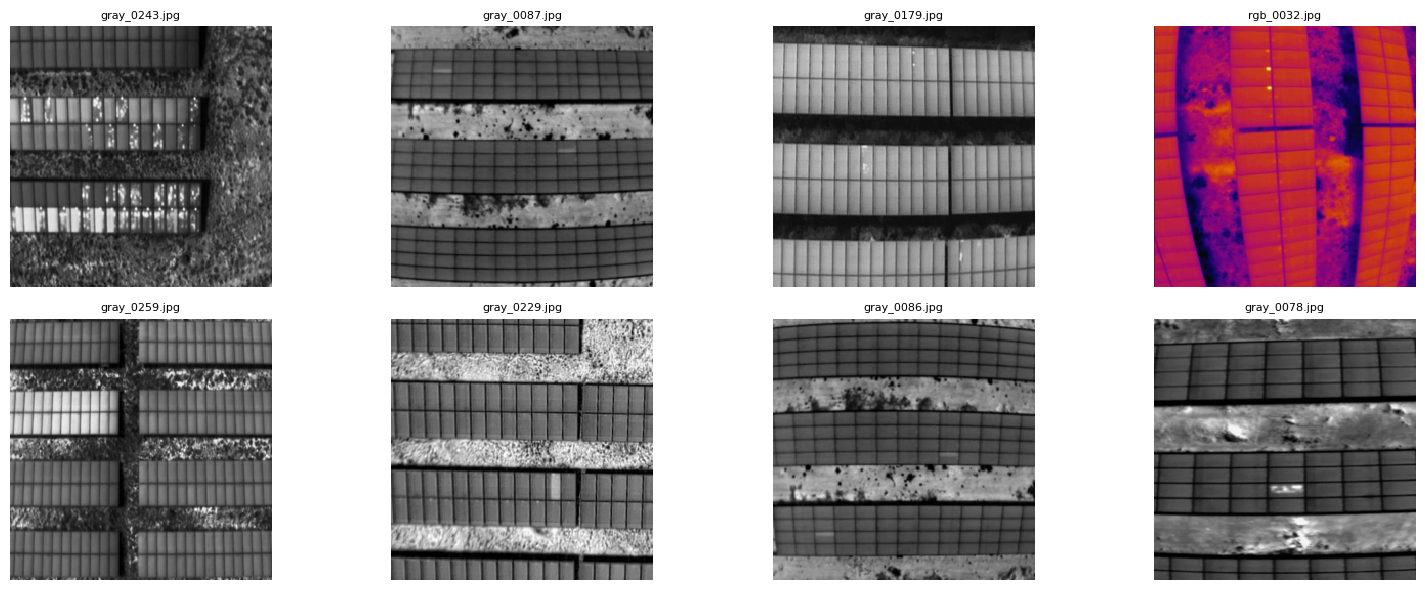

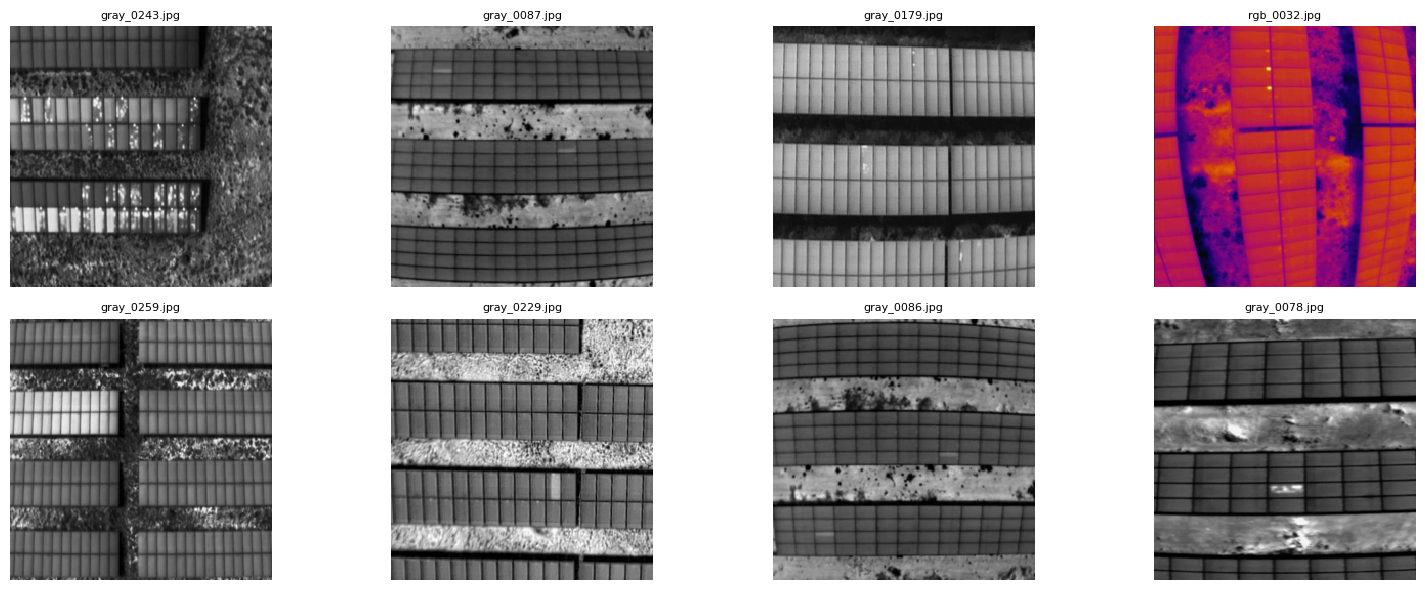

In [10]:
def show_images_grid(paths, ncols=4, thumb_size=(256,256), titles=None, cmap=None):
    n = len(paths)
    ncols = min(ncols, n) or 1
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    axes = np.array(axes).reshape(-1)
    for ax in axes[n:]:
        ax.axis("off")
    for i, p in enumerate(paths):
        ax = axes[i]
        try:
            img = Image.open(p)
            if thumb_size:
                img = ImageOps.exif_transpose(img)
                img.thumbnail(thumb_size)
            ax.imshow(np.asarray(img))
            ax.axis("off")
            if titles:
                ax.set_title(titles[i])
            else:
                ax.set_title(p.name, fontsize=8)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha='center')
            ax.axis("off")
    plt.tight_layout()
    return fig

# Show a few random images (non-mask)
sample_nonmask = random.sample(others, min(8, len(others)))
show_images_grid(sample_nonmask, ncols=4)


# display pairs (image, mask)

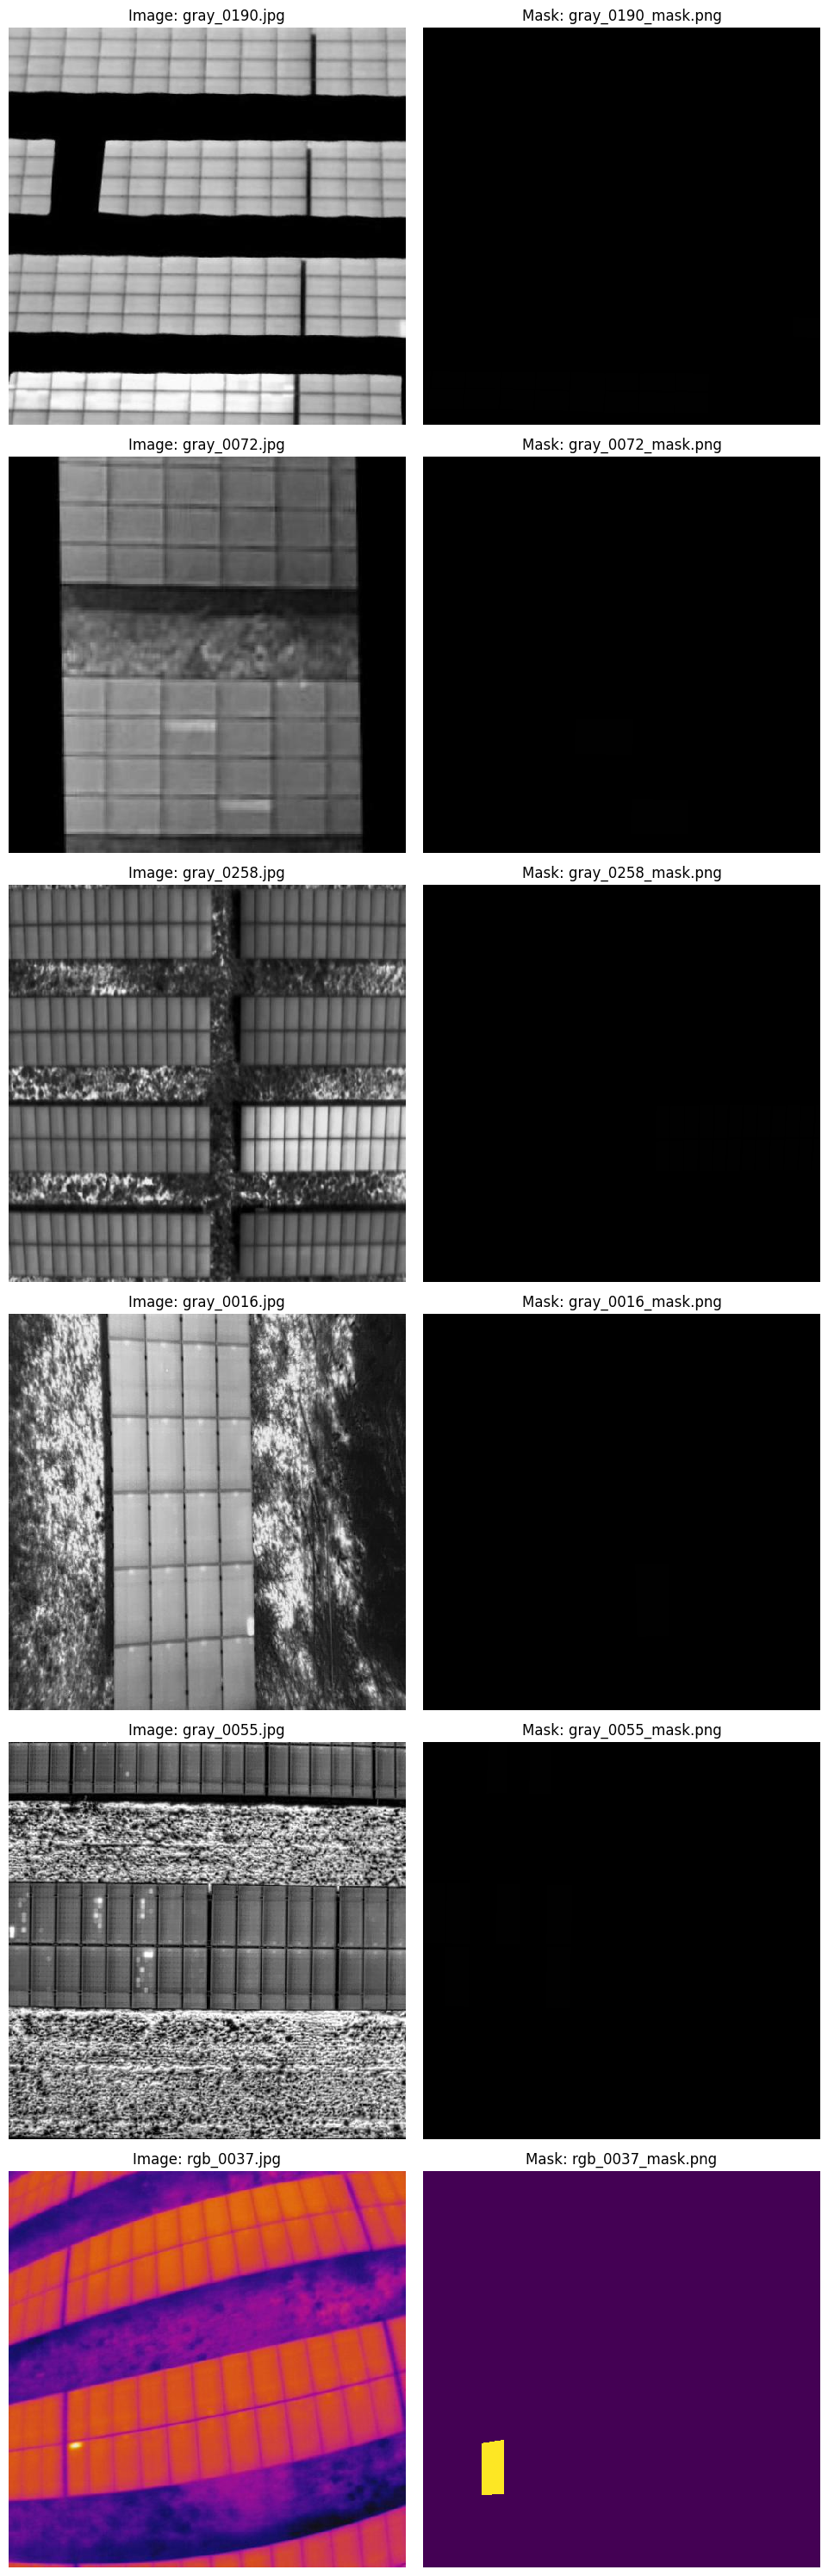

In [11]:
# find rows with at least one detected mask
paired_rows = df[df['mask_paths'].map(len) > 0]
if len(paired_rows) == 0:
    print("No image-mask pairs were detected by name heuristic. If your masks are in a separate folder or use unusual names, adapt the pairing logic.")
else:
    # show up to 6 pairs
    sample_pairs = paired_rows.sample(min(6, len(paired_rows)))
    fig, axes = plt.subplots(len(sample_pairs), 2, figsize=(10, 5*len(sample_pairs)))
    for i, (_, r) in enumerate(sample_pairs.iterrows()):
        img_p = r['image_path']
        mask_p = r['mask_paths'][0]
        with Image.open(img_p) as im:
            axes[i,0].imshow(np.asarray(ImageOps.exif_transpose(im)))
            axes[i,0].set_title(f"Image: {img_p.name}")
            axes[i,0].axis('off')
        try:
            with Image.open(mask_p) as m:
                axes[i,1].imshow(np.asarray(ImageOps.exif_transpose(m)))
                axes[i,1].set_title(f"Mask: {mask_p.name}")
                axes[i,1].axis('off')
        except Exception as e:
            axes[i,1].text(0.5,0.5, f"Mask read error: {e}")
            axes[i,1].axis('off')
    plt.tight_layout()


# 5. Image size distribution & aspect ratios

Images counted: 648


w      h      area  aspect
count  648.0  648.0     648.0   648.0
mean   512.0  512.0  262144.0     1.0
std      0.0    0.0       0.0     0.0
min    512.0  512.0  262144.0     1.0
25%    512.0  512.0  262144.0     1.0
50%    512.0  512.0  262144.0     1.0
75%    512.0  512.0  262144.0     1.0
max    512.0  512.0  262144.0     1.0

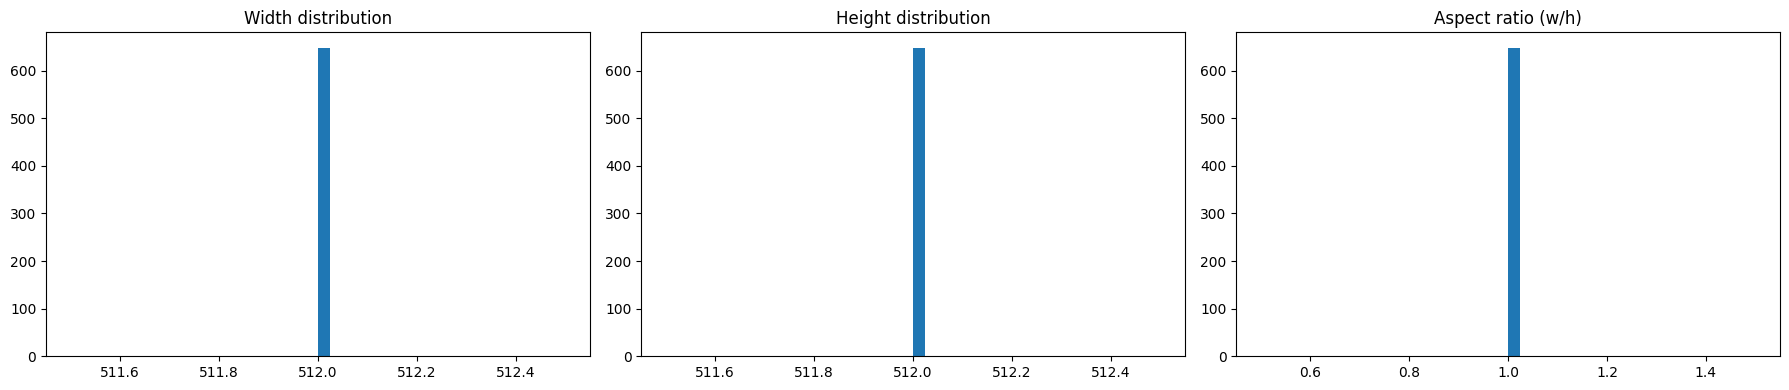

In [12]:
# %%
# build a DataFrame of image sizes
size_rows = []
for p, (w,h) in shapes.items():
    size_rows.append({"path": p, "w": w, "h": h, "area": w*h, "aspect": w/h if h!=0 else np.nan})
sizes_df = pd.DataFrame(size_rows)
print("Images counted:", len(sizes_df))
display(sizes_df.describe())

# plot histograms
fig, axs = plt.subplots(1,3, figsize=(18,4))
axs[0].hist(sizes_df['w'], bins=40)
axs[0].set_title("Width distribution")
axs[1].hist(sizes_df['h'], bins=40)
axs[1].set_title("Height distribution")
axs[2].hist(sizes_df['aspect'], bins=40)
axs[2].set_title("Aspect ratio (w/h)")
plt.tight_layout()


# 6. Pixel value statistics (sample subset to avoid memory blowup)
# - Per-channel mean/std
# - Pixel histograms

Per-channel mean (sampled): [0.21115704 0.18582284 0.19245073]
Per-channel std  (sampled): [0.10472284 0.09995896 0.10052443]


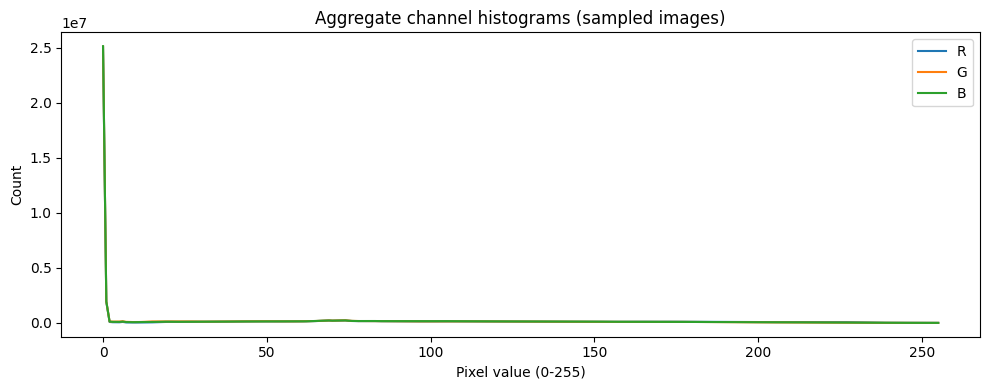

In [13]:
# %%
# sample up to N images for pixel statistics
N = 200
sample_for_stats = random.sample(sample_paths, min(N, len(sample_paths)))
means = []
stds = []
hist_bins = 256
acc_hist = np.zeros((3, hist_bins), dtype=np.int64)  # R,G,B

for p in sample_for_stats:
    try:
        im = cv2.imdecode(np.fromfile(str(p), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        if im is None:
            continue
        # cv2 loads as BGR by default
        if im.ndim == 2:
            # grayscale -> replicate
            im = np.stack([im]*3, axis=-1)
        elif im.shape[2] == 4:
            # drop alpha
            im = im[...,:3]
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = im.astype(np.float32) / 255.0
        means.append(im.mean(axis=(0,1)))
        stds.append(im.std(axis=(0,1)))
        for ch in range(3):
            h, _ = np.histogram((im[...,ch]*255).astype(int), bins=hist_bins, range=(0,255))
            acc_hist[ch] += h
    except Exception as e:
        # ignore read errors in stats sampling
        continue

means = np.array(means)
stds = np.array(stds)
print("Per-channel mean (sampled):", means.mean(axis=0))
print("Per-channel std  (sampled):", stds.mean(axis=0))

# plot channel histograms
fig, ax = plt.subplots(1,1, figsize=(10,4))
channels = ["R","G","B"]
for i,ch in enumerate(channels):
    ax.plot(np.arange(hist_bins), acc_hist[i], label=ch)
ax.set_xlabel("Pixel value (0-255)")
ax.set_ylabel("Count")
ax.legend()
ax.set_title("Aggregate channel histograms (sampled images)")
plt.tight_layout()


# 7. If masks are present: examine classes and coverage
# - Works best if masks are integer-labelled (0,1,2...) or colored segmentation maps.
# - We'll try to infer classes by unique pixel values / colors.

In [14]:
# %%
def analyze_mask(mask_path: Path):
    try:
        m = Image.open(mask_path)
        m = ImageOps.exif_transpose(m)
        arr = np.asarray(m)
        if arr.ndim == 3:
            # color mask: reduce to tuples
            flat = arr.reshape(-1, arr.shape[-1])
            uniq = np.unique(flat, axis=0)
            uniq_list = [tuple(u.tolist()) for u in uniq]
            return {"type":"color", "unique_colors": uniq_list, "shape": arr.shape}
        else:
            uniq = np.unique(arr)
            return {"type":"grayscale", "unique_values": uniq.tolist(), "shape": arr.shape}
    except Exception as e:
        return {"error": str(e), "path": str(mask_path)}

# analyze up to K masks
K = 100
mask_paths_to_check = random.sample(candidate_masks, min(K, len(candidate_masks)))
mask_analysis = [analyze_mask(p) for p in mask_paths_to_check]

# summarize
color_count = sum(1 for a in mask_analysis if a.get("type") == "color")
gray_count = sum(1 for a in mask_analysis if a.get("type") == "grayscale")
errors = [a for a in mask_analysis if "error" in a]
print(f"Checked {len(mask_analysis)} masks: color={color_count}, grayscale={gray_count}, errors={len(errors)}")
# show some examples
for i,a in enumerate(mask_analysis[:8]):
    print(i, a if len(str(a)) < 200 else str(a)[:200]+"...")


Checked 100 masks: color=87, grayscale=13, errors=0
0 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
1 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
2 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
3 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
4 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
5 {'type': 'grayscale', 'unique_values': [0, 1], 'shape': (512, 512)}
6 {'type': 'color', 'unique_colors': [(0, 0, 0), (1, 1, 1)], 'shape': (512, 512, 3)}
7 {'type': 'grayscale', 'unique_values': [0, 1], 'shape': (512, 512)}


# compute class pixel counts across dataset (sampled)

In [15]:
# %%
# gather global counts of mask classes (sampled)
class_counts = Counter()
for p in mask_paths_to_check:
    try:
        arr = np.asarray(Image.open(p).convert("L"))  # to grayscale ints
        vals, cnts = np.unique(arr, return_counts=True)
        for v,c in zip(vals, cnts):
            class_counts[int(v)] += int(c)
    except Exception:
        continue

print("Mask class pixel counts (sampled masks):")
for k,v in sorted(class_counts.items()):
    print(f"Class {k}: {v} pixels ({v/ sum(class_counts.values()):.2%})")


Mask class pixel counts (sampled masks):
Class 0: 24362189 pixels (92.93%)
Class 1: 1852211 pixels (7.07%)


# 8. Edge-case checks & data quality notes
### - Very small images (tiny w/h)
### - Unusual aspect ratios
### - Images missing masks
### - Transparent images with alpha channel
### - Very imbalanced mask classes

In [16]:
tiny_images = [p for p,(w,h) in shapes.items() if w < 64 or h < 64]
wide_images = [p for p,(w,h) in shapes.items() if max(w/h, h/w) > 4.0]
alpha_images = [p for p in images if Image.open(p).mode == "RGBA" or Image.open(p).mode == "LA"]

print("Tiny images (<64px):", len(tiny_images))
print("Extreme aspect ratio images (>4:1):", len(wide_images))
print("Images with alpha channel (RGBA):", len(alpha_images))

# Images without masks (from earlier df)
no_mask_df = df[df['mask_paths'].map(len)==0]
print("Images without detected masks (heuristic):", len(no_mask_df))
display(no_mask_df.head(10))


Tiny images (<64px): 0
Extreme aspect ratio images (>4:1): 0
Images with alpha channel (RGBA): 0
Images without detected masks (heuristic): 0


Empty DataFrame
Columns: [image_path, mask_paths]
Index: []

# 9. Save some helpful summary CSVs for use later (train/val lists, problematic files)

In [17]:
# %%
# master images list
master_images = pd.DataFrame([{"path": str(p), "size": shapes.get(p)} for p in images])
master_images.to_csv(OUT_DIR/"images_master_list.csv", index=False)

# pairs summary (image -> first detected mask)
pairs_df = pd.DataFrame([{"image": str(r['image_path']), "mask": str(r['mask_paths'][0]) if r['mask_paths'] else ""} for _,r in df.iterrows()])
pairs_df.to_csv(OUT_DIR/"image_mask_pairs.csv", index=False)

# problem files
problem_files = {"corrupt": [str(c[0]) for c in corrupt],
                 "tiny_images": [str(p) for p in tiny_images],
                 "alpha_images": [str(p) for p in alpha_images]}
with open(OUT_DIR/"problem_files_summary.json", "w") as f:
    json.dump(problem_files, f, indent=2)

print("Saved CSVs and problems JSON to:", OUT_DIR)


Saved CSVs and problems JSON to: /kaggle/working/solar_cells_eda_outputs


# More Extensive EDA in more detail


SECTION 1: DATASET STRUCTURE & PAIRING ANALYSIS

🔍 Scanning dataset...

📂 TRAIN Split Analysis:
   Total files: 518
   Image files (.jpg): 259
   Mask files (_mask.png): 259
   ✅ Properly paired: 259
   ⚠️  Unpaired images: 0
   ⚠️  Unpaired masks: 0

📂 VAL Split Analysis:
   Total files: 130
   Image files (.jpg): 65
   Mask files (_mask.png): 65
   ✅ Properly paired: 65
   ⚠️  Unpaired images: 0
   ⚠️  Unpaired masks: 0

✅ DATASET SUMMARY
Total paired samples: 324
Training samples: 259
Validation samples: 65
Train/Val ratio: 3.98:1

SECTION 2: METADATA EXTRACTION

📊 Extracting metadata from all pairs...
✅ Metadata extraction complete!

SECTION 3: BASIC STATISTICS

📈 Image Statistics:
   Dimensions: [512] x [512]
   Modes: ['RGB']
   Channels: [3]
   Avg size: 54.55 KB
   Total size: 17.26 MB

🎭 Mask Statistics:
   Dimensions: [512] x [512]
   Modes: ['RGB' 'L']
   Channels: [3 2]
   Avg size: 3.45 KB
   Total size: 1.09 MB

✅ Dimension Matching:
   All pairs match: True

SECTION 4: 

Mask Analysis: 100%|██████████| 100/100 [00:01<00:00, 81.87it/s]



📊 Mask Analysis Results:
   Samples analyzed: 100
   Unique class counts: [2]
   Global unique classes: [0, 1]
   Number of classes: 2

📈 Background vs Foreground:
   Avg background ratio: 92.25%
   Min background ratio: 47.33%
   Max background ratio: 99.67%

SECTION 5: IMAGE QUALITY METRICS

🔬 Analyzing quality for 100 images...


Quality Analysis: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]



📊 Quality Metrics Summary:
       brightness    contrast    sharpness  noise_estimate  dynamic_range
count  100.000000  100.000000   100.000000      100.000000     100.000000
mean   101.656197   50.864878   328.727132      119.190037     236.710000
std     21.952599   13.196859   457.168083        5.199013      16.782203
min     21.428791   22.805813     8.583400       83.915718     139.000000
25%     85.775355   41.728518    69.349271      117.994156     227.000000
50%    108.589836   52.978726   167.371974      120.967978     242.500000
75%    117.696669   61.731824   430.493414      122.022909     248.000000
max    144.866135   74.985217  2526.133500      124.416841     255.000000

🎨 Color Statistics:
   Avg brightness: 101.66
   Avg contrast: 50.86
   Avg sharpness: 328.73
   Avg noise: 119.19

SECTION 6: VISUALIZATION - DATASET OVERVIEW


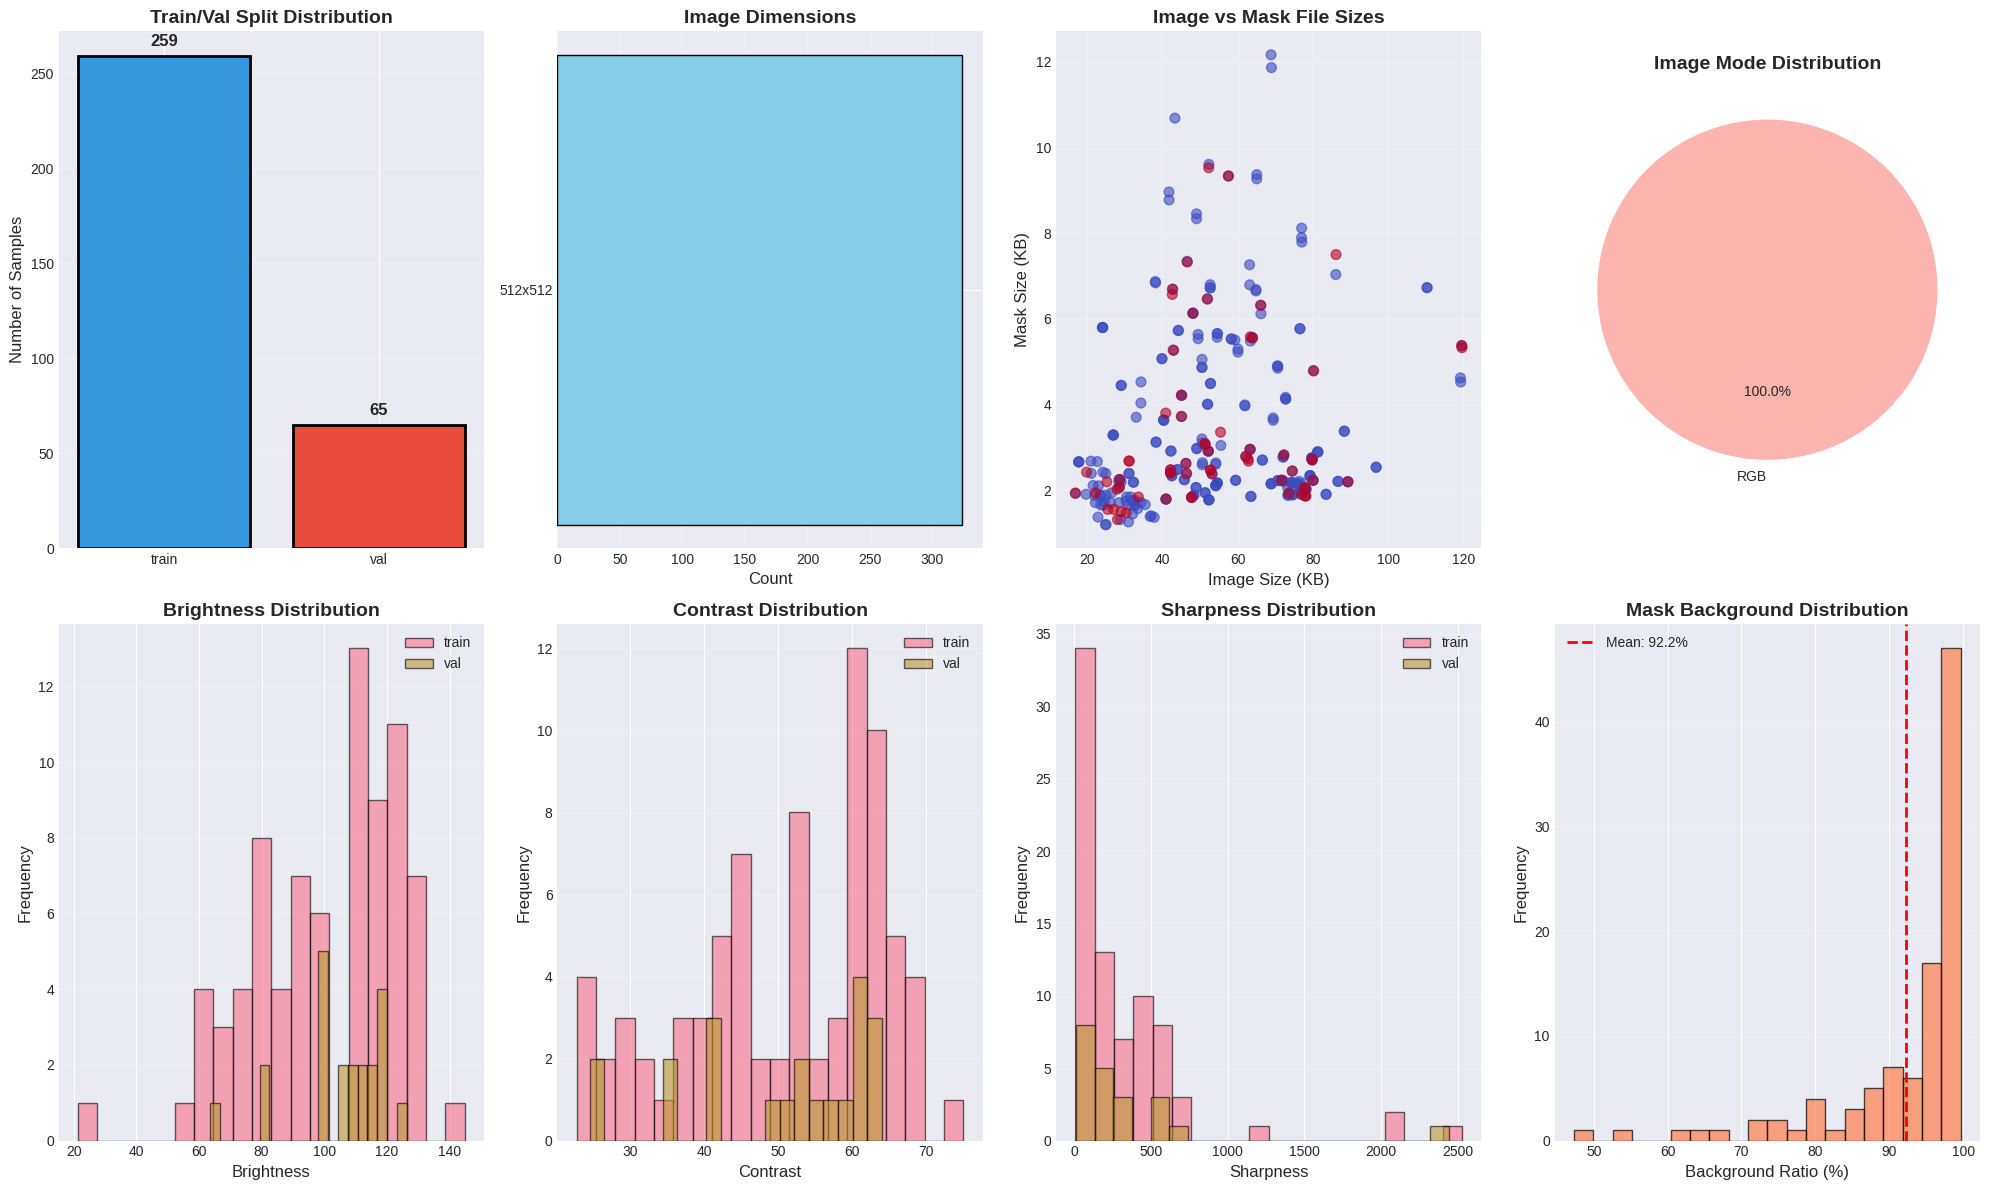

✅ Dataset overview saved!

SECTION 7: SAMPLE IMAGE-MASK PAIRS

🖼️  Generating sample visualizations...


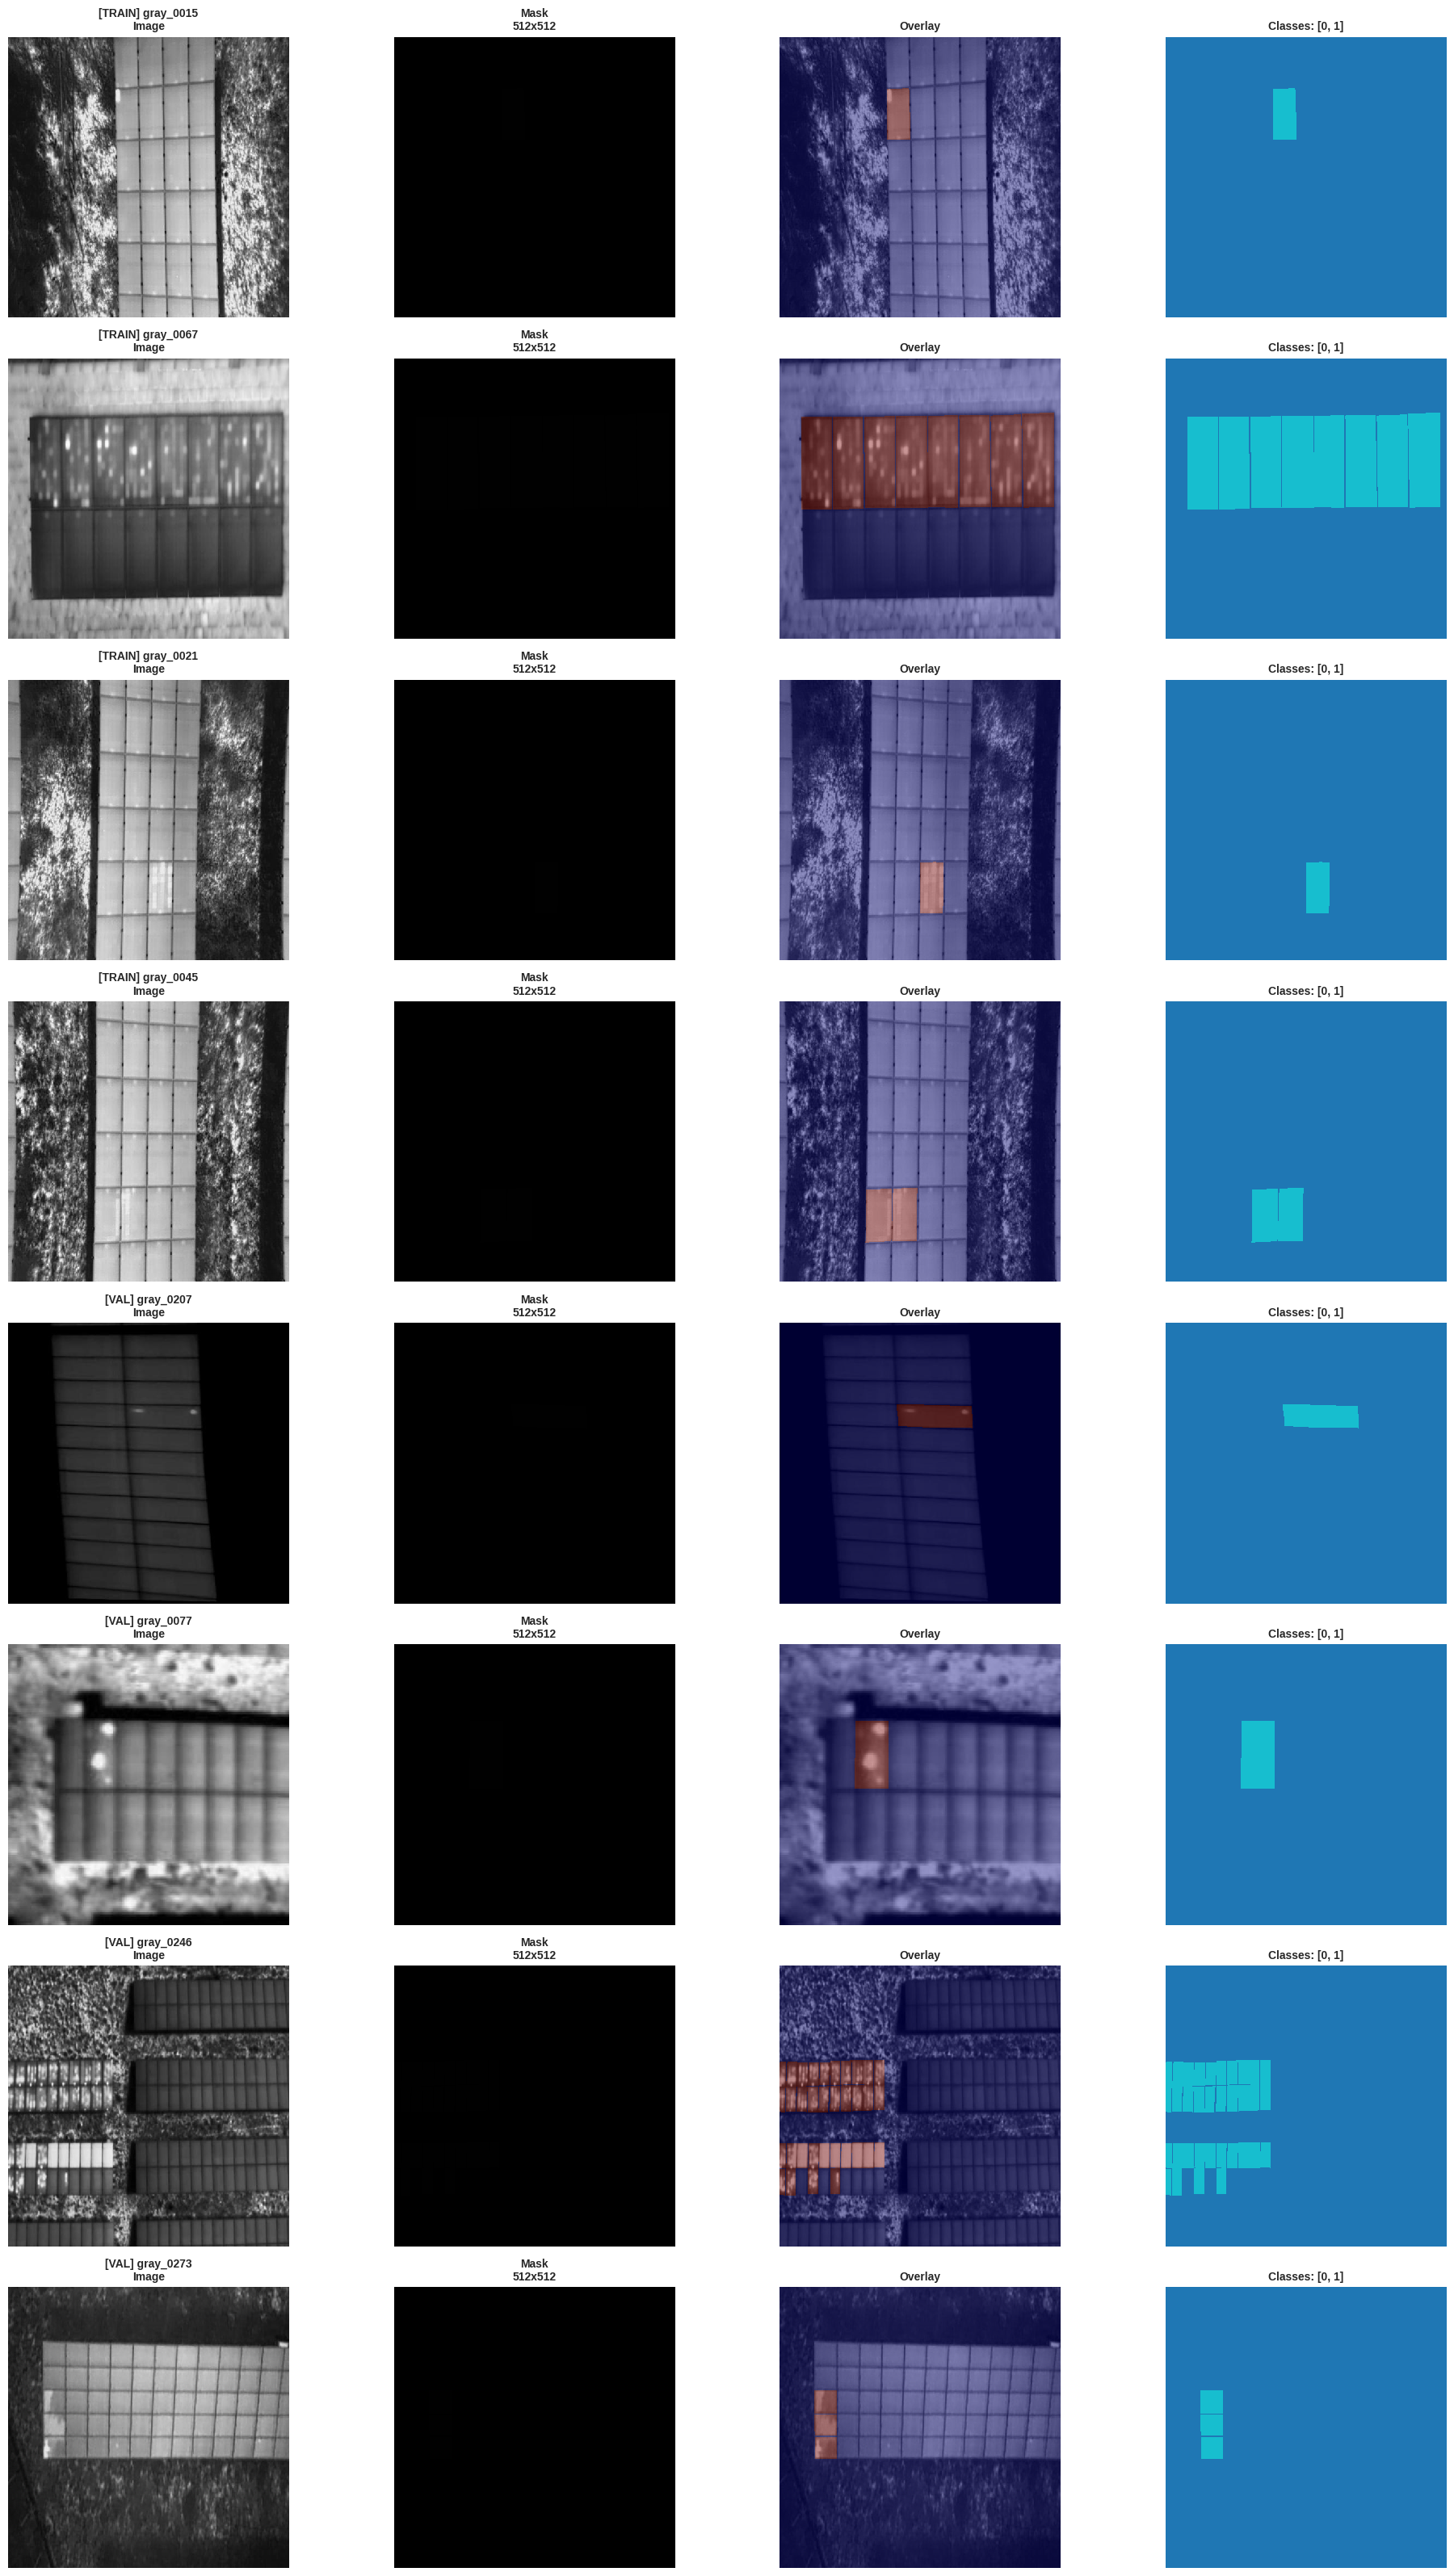

✅ Sample pairs saved!

SECTION 8: PIXEL-LEVEL STATISTICS

🔬 Computing pixel statistics for 50 samples...


Pixel Analysis: 100%|██████████| 50/50 [00:00<00:00, 67.13it/s]



📊 Pixel Statistics Summary:

RGB Channel Means:
   Red:   99.71 ± 52.88
   Green: 93.12 ± 51.93
   Blue:  108.79 ± 56.03

🎯 Mask Coverage:
   Average: 6.93%
   Min: 0.43%
   Max: 45.09%


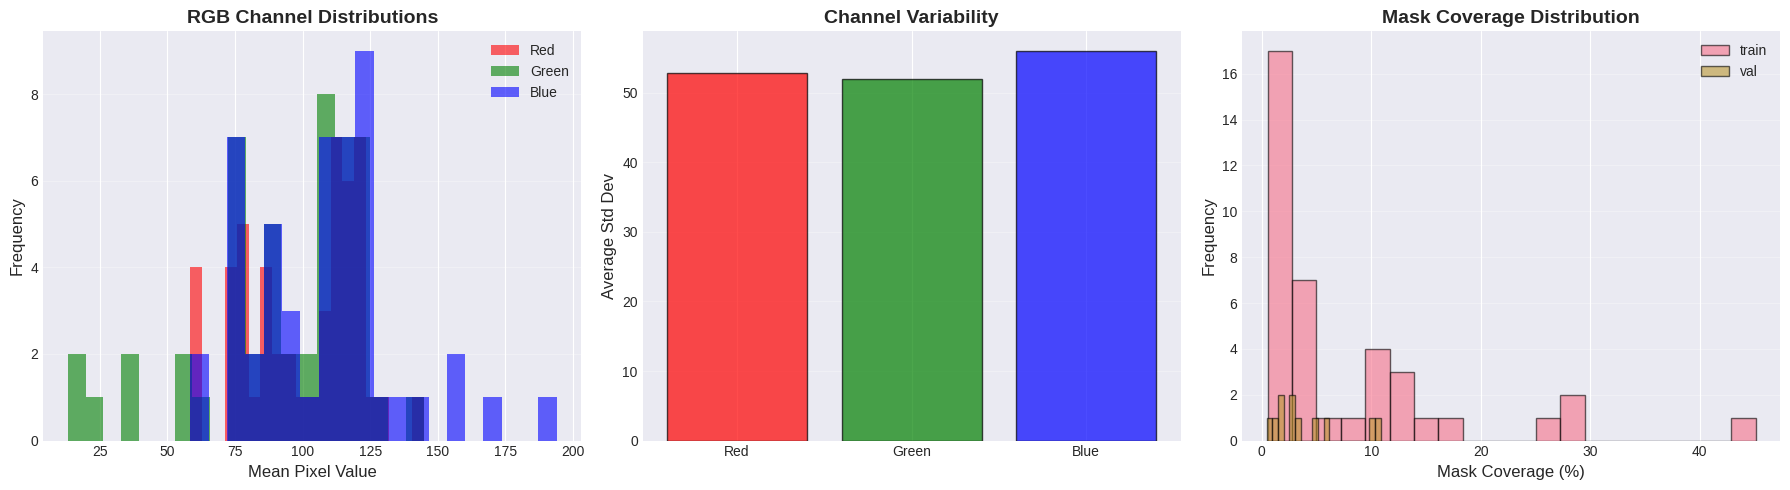

✅ Pixel statistics saved!

SECTION 9: SEGMENTATION-SPECIFIC METRICS

📊 Global Class Statistics:
   Total unique classes found: 2

   Class | Occurrences | Total Pixels | Avg Pixels/Image
   ------------------------------------------------------------
       0 |         100 |   24,181,934 |       241,819.3
       1 |         100 |    2,032,466 |        20,324.7


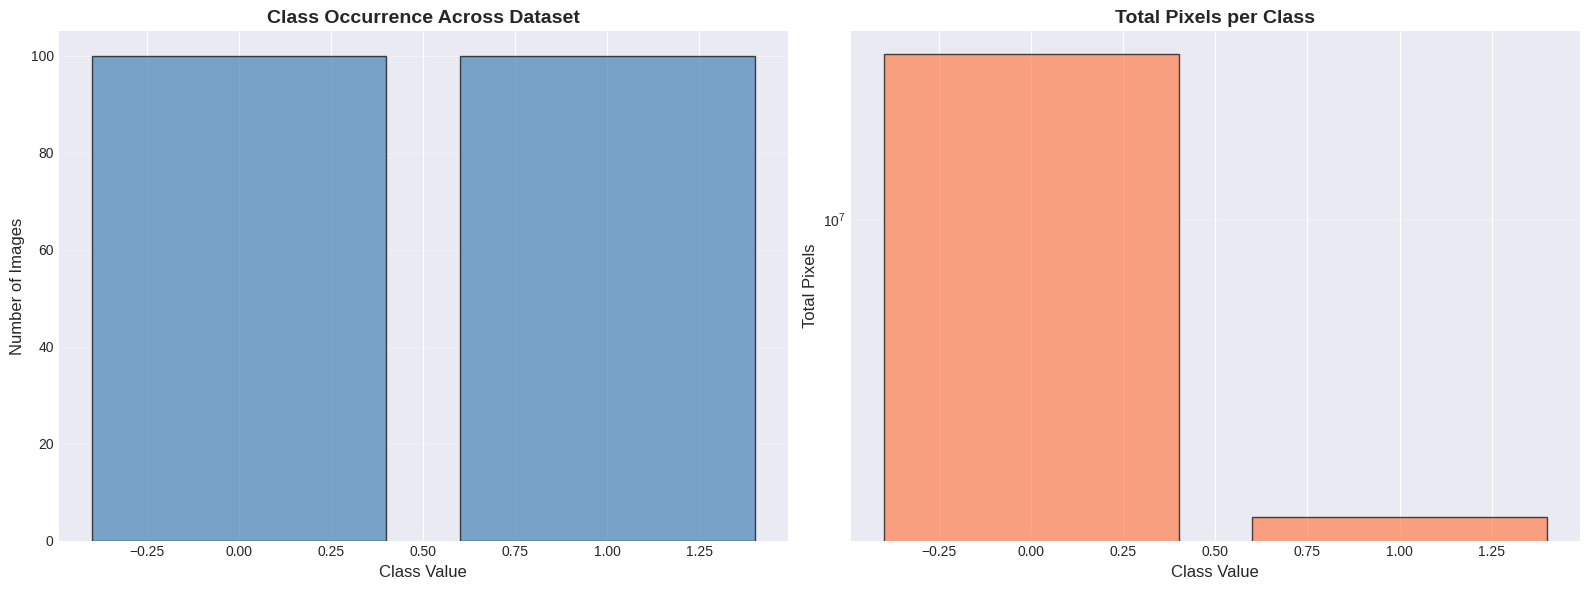


✅ Class distribution saved!

SECTION 10: DATA QUALITY ASSESSMENT

🔍 Quality Checks:
   ✓ Dimension mismatches: 0
   ✓ Missing image files: 0
   ✓ Missing mask files: 0
   ✓ Duplicate base names: 0
   ✓ File size anomalies (3σ): 5

✅ Data Completeness:
   Total expected pairs: 324
   Complete pairs: 324
   Completeness: 100.00%

SECTION 11: EXPORT REPORTS & SUMMARIES

📄 Summary Report:
{
  "dataset_info": {
    "name": "Solar Cell Segmentation Dataset",
    "type": "Semantic Segmentation (Image-Mask Pairs)",
    "total_samples": 324,
    "train_samples": 259,
    "val_samples": 65,
    "train_val_ratio": "3.98:1"
  },
  "image_specs": {
    "dimensions": {
      "(512, 512)": 324
    },
    "modes": {
      "RGB": 324
    },
    "formats": {
      "JPEG": 324
    },
    "avg_size_kb": 54.55,
    "total_size_mb": 17.26
  },
  "mask_specs": {
    "dimensions": {
      "(512, 512)": 324
    },
    "modes": {
      "RGB": 273,
      "L": 51
    },
    "avg_size_kb": 3.45,
    "total_size_m

In [36]:

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
np.random.seed(42)


# ============================================================================
# 2. DATASET STRUCTURE EXPLORATION
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 1: DATASET STRUCTURE & PAIRING ANALYSIS")
print("=" * 80)

# Define base paths
BASE_PATH = '/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VAL_PATH = os.path.join(BASE_PATH, 'val')

def analyze_paired_dataset(split_path, split_name):
    """Analyze image-mask pairs in a split"""
    
    if not os.path.exists(split_path):
        print(f"   ❌ Path not found: {split_path}")
        return pd.DataFrame()
    
    all_files = os.listdir(split_path)
    
    # Separate images and masks
    images = [f for f in all_files if f.endswith('.jpg')]
    masks = [f for f in all_files if f.endswith('_mask.png')]
    
    print(f"\n📂 {split_name.upper()} Split Analysis:")
    print(f"   Total files: {len(all_files)}")
    print(f"   Image files (.jpg): {len(images)}")
    print(f"   Mask files (_mask.png): {len(masks)}")
    
    # Create pairing information
    pairs_data = []
    unpaired_images = []
    unpaired_masks = []
    
    # Check for proper pairing
    for img_file in images:
        base_name = img_file.replace('.jpg', '')
        expected_mask = f"{base_name}_mask.png"
        
        if expected_mask in masks:
            pairs_data.append({
                'base_name': base_name,
                'image_file': img_file,
                'mask_file': expected_mask,
                'image_path': os.path.join(split_path, img_file),
                'mask_path': os.path.join(split_path, expected_mask),
                'split': split_name
            })
        else:
            unpaired_images.append(img_file)
    
    # Check for orphaned masks
    paired_masks = [p['mask_file'] for p in pairs_data]
    unpaired_masks = [m for m in masks if m not in paired_masks]
    
    print(f"   ✅ Properly paired: {len(pairs_data)}")
    print(f"   ⚠️  Unpaired images: {len(unpaired_images)}")
    print(f"   ⚠️  Unpaired masks: {len(unpaired_masks)}")
    
    if unpaired_images:
        print(f"   Unpaired images sample: {unpaired_images[:3]}")
    if unpaired_masks:
        print(f"   Unpaired masks sample: {unpaired_masks[:3]}")
    
    return pd.DataFrame(pairs_data)

# Collect data from both splits
print("\n🔍 Scanning dataset...")
train_df = analyze_paired_dataset(TRAIN_PATH, 'train')
val_df = analyze_paired_dataset(VAL_PATH, 'val')

# Combine datasets
df = pd.concat([train_df, val_df], ignore_index=True)

print(f"\n" + "=" * 80)
print(f"✅ DATASET SUMMARY")
print(f"=" * 80)
print(f"Total paired samples: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if len(val_df) > 0:
    print(f"Train/Val ratio: {len(train_df)/len(val_df):.2f}:1")
else:
    print(f"Train/Val ratio: N/A")

# ============================================================================
# 3. DETAILED IMAGE AND MASK METADATA COLLECTION
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 2: METADATA EXTRACTION")
print("=" * 80)

def extract_metadata(row):
    """Extract detailed metadata for image-mask pair"""
    try:
        # Load image
        img = Image.open(row['image_path'])
        img_array = np.array(img)
        
        # Load mask
        mask = Image.open(row['mask_path'])
        mask_array = np.array(mask)
        
        metadata = {
            'img_width': img.width,
            'img_height': img.height,
            'img_mode': img.mode,
            'img_format': img.format,
            'img_size_bytes': os.path.getsize(row['image_path']),
            'img_channels': len(img_array.shape) if len(img_array.shape) == 2 else img_array.shape[2],
            
            'mask_width': mask.width,
            'mask_height': mask.height,
            'mask_mode': mask.mode,
            'mask_format': mask.format,
            'mask_size_bytes': os.path.getsize(row['mask_path']),
            'mask_channels': len(mask_array.shape) if len(mask_array.shape) == 2 else mask_array.shape[2],
            
            'dimension_match': (img.width == mask.width) and (img.height == mask.height)
        }
        
        img.close()
        mask.close()
        
        return pd.Series(metadata)
    except Exception as e:
        print(f"❌ Error processing {row['base_name']}: {e}")
        return pd.Series({})

print("\n📊 Extracting metadata from all pairs...")
metadata_df = df.apply(extract_metadata, axis=1)
df = pd.concat([df, metadata_df], axis=1)

print("✅ Metadata extraction complete!")

# ============================================================================
# 4. BASIC STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 3: BASIC STATISTICS")
print("=" * 80)

# Add size in KB for easier reading
df['img_size_kb'] = df['img_size_bytes'] / 1024
df['mask_size_kb'] = df['mask_size_bytes'] / 1024

print("\n📈 Image Statistics:")
print(f"   Dimensions: {df['img_width'].unique()} x {df['img_height'].unique()}")
print(f"   Modes: {df['img_mode'].unique()}")
print(f"   Channels: {df['img_channels'].unique()}")
print(f"   Avg size: {df['img_size_kb'].mean():.2f} KB")
print(f"   Total size: {df['img_size_bytes'].sum()/(1024**2):.2f} MB")

print("\n🎭 Mask Statistics:")
print(f"   Dimensions: {df['mask_width'].unique()} x {df['mask_height'].unique()}")
print(f"   Modes: {df['mask_mode'].unique()}")
print(f"   Channels: {df['mask_channels'].unique()}")
print(f"   Avg size: {df['mask_size_kb'].mean():.2f} KB")
print(f"   Total size: {df['mask_size_bytes'].sum()/(1024**2):.2f} MB")

print("\n✅ Dimension Matching:")
print(f"   All pairs match: {df['dimension_match'].all()}")
if not df['dimension_match'].all():
    print(f"   Mismatched pairs: {(~df['dimension_match']).sum()}")

# ============================================================================
# 5. DETAILED MASK ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 4: MASK ANALYSIS - CLASS DISTRIBUTION")
print("=" * 80)

def analyze_mask_content(sample_size=100):
    """Analyze mask content - unique values, class distribution"""
    mask_analysis = []
    
    # Sample masks for analysis
    sample_size = min(sample_size, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_df = df.iloc[sample_indices]
    
    print(f"\n🔬 Analyzing {len(sample_df)} mask samples...")
    
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Mask Analysis"):
        try:
            mask = cv2.imread(row['mask_path'], cv2.IMREAD_UNCHANGED)
            
            if mask is None:
                continue
            
            # If multi-channel, convert to single channel
            if len(mask.shape) == 3:
                mask = mask[:, :, 0]
            
            unique_values = np.unique(mask)
            value_counts = {int(val): int(np.sum(mask == val)) for val in unique_values}
            
            mask_analysis.append({
                'base_name': row['base_name'],
                'split': row['split'],
                'unique_classes': len(unique_values),
                'class_values': unique_values.tolist(),
                'class_pixel_counts': value_counts,
                'total_pixels': mask.size,
                'background_ratio': value_counts.get(0, 0) / mask.size if 0 in value_counts else 0,
                'mask_mean': float(np.mean(mask)),
                'mask_std': float(np.std(mask))
            })
            
        except Exception as e:
            print(f"   ⚠️  Error analyzing {row['base_name']}: {e}")
            continue
    
    return pd.DataFrame(mask_analysis)

mask_df = analyze_mask_content()

if len(mask_df) > 0:
    print("\n📊 Mask Analysis Results:")
    print(f"   Samples analyzed: {len(mask_df)}")
    print(f"   Unique class counts: {mask_df['unique_classes'].unique()}")
    
    # Global class distribution
    all_classes = set()
    for classes in mask_df['class_values']:
        all_classes.update(classes)
    
    print(f"   Global unique classes: {sorted(all_classes)}")
    print(f"   Number of classes: {len(all_classes)}")
    
    print("\n📈 Background vs Foreground:")
    print(f"   Avg background ratio: {mask_df['background_ratio'].mean()*100:.2f}%")
    print(f"   Min background ratio: {mask_df['background_ratio'].min()*100:.2f}%")
    print(f"   Max background ratio: {mask_df['background_ratio'].max()*100:.2f}%")

# ============================================================================
# 6. IMAGE QUALITY ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 5: IMAGE QUALITY METRICS")
print("=" * 80)

def analyze_image_quality(sample_size=100):
    """Comprehensive image quality analysis"""
    quality_metrics = []
    
    sample_size = min(sample_size, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_df = df.iloc[sample_indices]
    
    print(f"\n🔬 Analyzing quality for {len(sample_df)} images...")
    
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Quality Analysis"):
        try:
            # Load image
            img = cv2.imread(row['image_path'])
            if img is None:
                continue
            
            # Convert to different color spaces
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # Brightness (mean intensity)
            brightness = np.mean(gray)
            
            # Contrast (standard deviation)
            contrast = np.std(gray)
            
            # Sharpness (Laplacian variance)
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)
            sharpness = laplacian.var()
            
            # Noise estimation (high-frequency content)
            noise = np.std(cv2.GaussianBlur(gray, (5,5), 0) - gray)
            
            # Color distribution
            color_std = np.std(img, axis=(0,1))
            
            # Dynamic range
            dynamic_range = gray.max() - gray.min()
            
            quality_metrics.append({
                'base_name': row['base_name'],
                'split': row['split'],
                'brightness': brightness,
                'contrast': contrast,
                'sharpness': sharpness,
                'noise_estimate': noise,
                'dynamic_range': dynamic_range,
                'color_std_b': color_std[0],
                'color_std_g': color_std[1],
                'color_std_r': color_std[2],
                'saturation_mean': np.mean(hsv[:,:,1]),
                'value_mean': np.mean(hsv[:,:,2])
            })
            
        except Exception as e:
            continue
    
    return pd.DataFrame(quality_metrics)

quality_df = analyze_image_quality()

if len(quality_df) > 0:
    print("\n📊 Quality Metrics Summary:")
    print(quality_df[['brightness', 'contrast', 'sharpness', 'noise_estimate', 'dynamic_range']].describe())
    
    print("\n🎨 Color Statistics:")
    print(f"   Avg brightness: {quality_df['brightness'].mean():.2f}")
    print(f"   Avg contrast: {quality_df['contrast'].mean():.2f}")
    print(f"   Avg sharpness: {quality_df['sharpness'].mean():.2f}")
    print(f"   Avg noise: {quality_df['noise_estimate'].mean():.2f}")

# ============================================================================
# 7. VISUALIZATION - DATASET OVERVIEW
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 6: VISUALIZATION - DATASET OVERVIEW")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))

# 1. Split distribution
ax1 = plt.subplot(2, 4, 1)
split_counts = df['split'].value_counts()
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(split_counts.index, split_counts.values, color=colors, edgecolor='black', linewidth=2)
ax1.set_title('Train/Val Split Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12)
for i, (bar, v) in enumerate(zip(bars, split_counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 5, str(v), 
             ha='center', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Image dimensions
ax2 = plt.subplot(2, 4, 2)
dim_str = df.apply(lambda x: f"{x['img_width']}x{x['img_height']}", axis=1)
dim_counts = dim_str.value_counts()
ax2.barh(range(len(dim_counts)), dim_counts.values, color='skyblue', edgecolor='black')
ax2.set_yticks(range(len(dim_counts)))
ax2.set_yticklabels(dim_counts.index)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_title('Image Dimensions', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. File size comparison
ax3 = plt.subplot(2, 4, 3)
ax3.scatter(df['img_size_kb'], df['mask_size_kb'], alpha=0.6, 
           c=df['split'].map({'train': 0, 'val': 1}), cmap='coolwarm', s=50)
ax3.set_xlabel('Image Size (KB)', fontsize=12)
ax3.set_ylabel('Mask Size (KB)', fontsize=12)
ax3.set_title('Image vs Mask File Sizes', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Image mode distribution
ax4 = plt.subplot(2, 4, 4)
mode_counts = df['img_mode'].value_counts()
ax4.pie(mode_counts.values, labels=mode_counts.index, autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Pastel1(range(len(mode_counts))))
ax4.set_title('Image Mode Distribution', fontsize=14, fontweight='bold')

# 5. Quality metrics - Brightness
if len(quality_df) > 0:
    ax5 = plt.subplot(2, 4, 5)
    for split in quality_df['split'].unique():
        data = quality_df[quality_df['split'] == split]['brightness']
        ax5.hist(data, alpha=0.6, label=split, bins=20, edgecolor='black')
    ax5.set_xlabel('Brightness', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title('Brightness Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Quality metrics - Contrast
    ax6 = plt.subplot(2, 4, 6)
    for split in quality_df['split'].unique():
        data = quality_df[quality_df['split'] == split]['contrast']
        ax6.hist(data, alpha=0.6, label=split, bins=20, edgecolor='black')
    ax6.set_xlabel('Contrast', fontsize=12)
    ax6.set_ylabel('Frequency', fontsize=12)
    ax6.set_title('Contrast Distribution', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    # 7. Quality metrics - Sharpness
    ax7 = plt.subplot(2, 4, 7)
    for split in quality_df['split'].unique():
        data = quality_df[quality_df['split'] == split]['sharpness']
        ax7.hist(data, alpha=0.6, label=split, bins=20, edgecolor='black')
    ax7.set_xlabel('Sharpness', fontsize=12)
    ax7.set_ylabel('Frequency', fontsize=12)
    ax7.set_title('Sharpness Distribution', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(axis='y', alpha=0.3)

# 8. Mask class distribution
if len(mask_df) > 0:
    ax8 = plt.subplot(2, 4, 8)
    bg_ratios = mask_df['background_ratio'] * 100
    ax8.hist(bg_ratios, bins=20, alpha=0.7, color='coral', edgecolor='black')
    ax8.axvline(bg_ratios.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {bg_ratios.mean():.1f}%')
    ax8.set_xlabel('Background Ratio (%)', fontsize=12)
    ax8.set_ylabel('Frequency', fontsize=12)
    ax8.set_title('Mask Background Distribution', fontsize=14, fontweight='bold')
    ax8.legend()
    ax8.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('01_dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Dataset overview saved!")

# ============================================================================
# 8. VISUALIZATION - SAMPLE IMAGE-MASK PAIRS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 7: SAMPLE IMAGE-MASK PAIRS")
print("=" * 80)

def visualize_pairs(df, n_samples=8):
    """Visualize random image-mask pairs"""
    
    # Sample from both splits
    n_train = min(n_samples//2, len(df[df['split'] == 'train']))
    n_val = min(n_samples//2, len(df[df['split'] == 'val']))
    
    train_samples = df[df['split'] == 'train'].sample(n=n_train) if n_train > 0 else pd.DataFrame()
    val_samples = df[df['split'] == 'val'].sample(n=n_val) if n_val > 0 else pd.DataFrame()
    samples = pd.concat([train_samples, val_samples])
    
    if len(samples) == 0:
        print("⚠️  No samples available for visualization")
        return
    
    fig = plt.figure(figsize=(20, 4*len(samples)))
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load image and mask
        img = Image.open(row['image_path'])
        mask = Image.open(row['mask_path'])
        
        # Original image
        ax1 = plt.subplot(len(samples), 4, idx*4 + 1)
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(f"[{row['split'].upper()}] {row['base_name']}\nImage", 
                     fontsize=10, fontweight='bold')
        
        # Mask
        ax2 = plt.subplot(len(samples), 4, idx*4 + 2)
        ax2.imshow(mask, cmap='gray')
        ax2.axis('off')
        ax2.set_title(f"Mask\n{row['mask_width']}x{row['mask_height']}", 
                     fontsize=10, fontweight='bold')
        
        # Overlay
        ax3 = plt.subplot(len(samples), 4, idx*4 + 3)
        ax3.imshow(img)
        mask_array = np.array(mask)
        if len(mask_array.shape) == 3:
            mask_array = mask_array[:,:,0]
        ax3.imshow(mask_array, alpha=0.4, cmap='jet')
        ax3.axis('off')
        ax3.set_title(f"Overlay", fontsize=10, fontweight='bold')
        
        # Mask unique values visualization
        ax4 = plt.subplot(len(samples), 4, idx*4 + 4)
        unique_vals = np.unique(mask_array)
        colors_used = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
        colored_mask = np.zeros((*mask_array.shape, 3))
        for i, val in enumerate(unique_vals):
            colored_mask[mask_array == val] = colors_used[i][:3]
        ax4.imshow(colored_mask)
        ax4.axis('off')
        ax4.set_title(f"Classes: {unique_vals.tolist()}", 
                     fontsize=10, fontweight='bold')
        
        img.close()
        mask.close()
    
    plt.tight_layout()
    plt.savefig('02_image_mask_pairs.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🖼️  Generating sample visualizations...")
visualize_pairs(df)
print("✅ Sample pairs saved!")

# ============================================================================
# 9. ADVANCED ANALYSIS - PIXEL STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 8: PIXEL-LEVEL STATISTICS")
print("=" * 80)

def analyze_pixel_statistics(sample_size=50):
    """Detailed pixel-level analysis"""
    pixel_stats = []
    
    sample_size = min(sample_size, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_df = df.iloc[sample_indices]
    
    print(f"\n🔬 Computing pixel statistics for {len(sample_df)} samples...")
    
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Pixel Analysis"):
        try:
            img = cv2.imread(row['image_path'])
            mask = cv2.imread(row['mask_path'], cv2.IMREAD_UNCHANGED)
            
            if img is None or mask is None:
                continue
            
            # Convert to appropriate formats
            if len(mask.shape) == 3:
                mask = mask[:,:,0]
            
            # RGB channel statistics
            r, g, b = cv2.split(img)
            
            pixel_stats.append({
                'base_name': row['base_name'],
                'split': row['split'],
                'r_mean': np.mean(r),
                'r_std': np.std(r),
                'g_mean': np.mean(g),
                'g_std': np.std(g),
                'b_mean': np.mean(b),
                'b_std': np.std(b),
                'r_min': np.min(r),
                'r_max': np.max(r),
                'g_min': np.min(g),
                'g_max': np.max(g),
                'b_min': np.min(b),
                'b_max': np.max(b),
                'mask_coverage': (np.sum(mask > 0) / mask.size) * 100
            })
            
        except Exception as e:
            continue
    
    return pd.DataFrame(pixel_stats)

pixel_df = analyze_pixel_statistics()

if len(pixel_df) > 0:
    print("\n📊 Pixel Statistics Summary:")
    print("\nRGB Channel Means:")
    print(f"   Red:   {pixel_df['r_mean'].mean():.2f} ± {pixel_df['r_std'].mean():.2f}")
    print(f"   Green: {pixel_df['g_mean'].mean():.2f} ± {pixel_df['g_std'].mean():.2f}")
    print(f"   Blue:  {pixel_df['b_mean'].mean():.2f} ± {pixel_df['b_std'].mean():.2f}")
    
    print("\n🎯 Mask Coverage:")
    print(f"   Average: {pixel_df['mask_coverage'].mean():.2f}%")
    print(f"   Min: {pixel_df['mask_coverage'].min():.2f}%")
    print(f"   Max: {pixel_df['mask_coverage'].max():.2f}%")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # RGB distribution
    ax = axes[0]
    ax.hist(pixel_df['r_mean'], alpha=0.6, label='Red', bins=20, color='red')
    ax.hist(pixel_df['g_mean'], alpha=0.6, label='Green', bins=20, color='green')
    ax.hist(pixel_df['b_mean'], alpha=0.6, label='Blue', bins=20, color='blue')
    ax.set_xlabel('Mean Pixel Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('RGB Channel Distributions', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Channel variance
    ax = axes[1]
    x = np.arange(3)
    means = [pixel_df['r_std'].mean(), pixel_df['g_std'].mean(), pixel_df['b_std'].mean()]
    ax.bar(x, means, color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(['Red', 'Green', 'Blue'])
    ax.set_ylabel('Average Std Dev', fontsize=12)
    ax.set_title('Channel Variability', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Mask coverage
    ax = axes[2]
    for split in pixel_df['split'].unique():
        data = pixel_df[pixel_df['split'] == split]['mask_coverage']
        ax.hist(data, alpha=0.6, label=split, bins=20, edgecolor='black')
    ax.set_xlabel('Mask Coverage (%)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Mask Coverage Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('03_pixel_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Pixel statistics saved!")

# ============================================================================
# 10. CLASS BALANCE AND SEGMENTATION METRICS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 9: SEGMENTATION-SPECIFIC METRICS")
print("=" * 80)

if len(mask_df) > 0:
    # Aggregate class statistics
    all_class_counts = defaultdict(int)
    all_class_pixels = defaultdict(int)
    
    for idx, row in mask_df.iterrows():
        for class_val, pixel_count in row['class_pixel_counts'].items():
            all_class_counts[class_val] += 1
            all_class_pixels[class_val] += pixel_count
    
    print("\n📊 Global Class Statistics:")
    print(f"   Total unique classes found: {len(all_class_counts)}")
    print("\n   Class | Occurrences | Total Pixels | Avg Pixels/Image")
    print("   " + "-" * 60)
    
    for class_val in sorted(all_class_counts.keys()):
        occurrences = all_class_counts[class_val]
        total_pixels = all_class_pixels[class_val]
        avg_pixels = total_pixels / occurrences
        print(f"   {class_val:5d} | {occurrences:11d} | {total_pixels:12,d} | {avg_pixels:15,.1f}")
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Class occurrence
    ax = axes[0]
    classes = sorted(all_class_counts.keys())
    counts = [all_class_counts[c] for c in classes]
    ax.bar(classes, counts, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Class Value', fontsize=12)
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.set_title('Class Occurrence Across Dataset', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Pixel distribution
    ax = axes[1]
    pixels = [all_class_pixels[c] for c in classes]
    ax.bar(classes, pixels, color='coral', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Class Value', fontsize=12)
    ax.set_ylabel('Total Pixels', fontsize=12)
    ax.set_title('Total Pixels per Class', fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('04_class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✅ Class distribution saved!")

# ============================================================================
# 11. DATA QUALITY CHECKS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 10: DATA QUALITY ASSESSMENT")
print("=" * 80)

print("\n🔍 Quality Checks:")

# Check for dimension mismatches
dimension_issues = df[~df['dimension_match']]
print(f"   ✓ Dimension mismatches: {len(dimension_issues)}")

# Check for missing files
missing_images = df[~df['image_path'].apply(os.path.exists)]
missing_masks = df[~df['mask_path'].apply(os.path.exists)]
print(f"   ✓ Missing image files: {len(missing_images)}")
print(f"   ✓ Missing mask files: {len(missing_masks)}")

# Check for duplicate base names
duplicates = df[df.duplicated(subset=['base_name'], keep=False)]
print(f"   ✓ Duplicate base names: {len(duplicates)}")

# Check file size anomalies
if len(df) > 0:
    img_size_mean = df['img_size_kb'].mean()
    img_size_std = df['img_size_kb'].std()
    size_anomalies = df[(df['img_size_kb'] < img_size_mean - 3*img_size_std) | 
                        (df['img_size_kb'] > img_size_mean + 3*img_size_std)]
    print(f"   ✓ File size anomalies (3σ): {len(size_anomalies)}")

# Data completeness
print(f"\n✅ Data Completeness:")
print(f"   Total expected pairs: {len(df)}")
print(f"   Complete pairs: {len(df[df['dimension_match']])}")
if len(df) > 0:
    print(f"   Completeness: {len(df[df['dimension_match']])/len(df)*100:.2f}%")

# ============================================================================
# 12. EXPORT COMPREHENSIVE REPORTS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 11: EXPORT REPORTS & SUMMARIES")
print("=" * 80)

# Create comprehensive summary
summary_report = {
    'dataset_info': {
        'name': 'Solar Cell Segmentation Dataset',
        'type': 'Semantic Segmentation (Image-Mask Pairs)',
        'total_samples': len(df),
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'train_val_ratio': f"{len(train_df)/len(val_df):.2f}:1" if len(val_df) > 0 else "N/A"
    },
    'image_specs': {
        'dimensions': {str(k): int(v) for k, v in df.groupby(['img_width', 'img_height']).size().to_dict().items()},
        'modes': df['img_mode'].value_counts().to_dict(),
        'formats': df['img_format'].value_counts().to_dict(),
        'avg_size_kb': round(df['img_size_kb'].mean(), 2) if len(df) > 0 else 0,
        'total_size_mb': round(df['img_size_bytes'].sum() / (1024**2), 2) if len(df) > 0 else 0
    },
    'mask_specs': {
        'dimensions': {str(k): int(v) for k, v in df.groupby(['mask_width', 'mask_height']).size().to_dict().items()},
        'modes': df['mask_mode'].value_counts().to_dict(),
        'avg_size_kb': round(df['mask_size_kb'].mean(), 2) if len(df) > 0 else 0,
        'total_size_mb': round(df['mask_size_bytes'].sum() / (1024**2), 2) if len(df) > 0 else 0
    }
}

if len(mask_df) > 0:
    summary_report['segmentation_stats'] = {
        'num_classes': len(all_class_counts),
        'class_values': sorted(all_class_counts.keys()),
        'avg_background_ratio': f"{mask_df['background_ratio'].mean()*100:.2f}%",
        'class_distribution': {int(k): int(v) for k, v in all_class_counts.items()}
    }

if len(quality_df) > 0:
    summary_report['quality_metrics'] = {
        'avg_brightness': round(quality_df['brightness'].mean(), 2),
        'avg_contrast': round(quality_df['contrast'].mean(), 2),
        'avg_sharpness': round(quality_df['sharpness'].mean(), 2),
        'avg_noise': round(quality_df['noise_estimate'].mean(), 2)
    }

if len(pixel_df) > 0:
    summary_report['pixel_statistics'] = {
        'rgb_means': {
            'red': round(pixel_df['r_mean'].mean(), 2),
            'green': round(pixel_df['g_mean'].mean(), 2),
            'blue': round(pixel_df['b_mean'].mean(), 2)
        },
        'rgb_stds': {
            'red': round(pixel_df['r_std'].mean(), 2),
            'green': round(pixel_df['g_std'].mean(), 2),
            'blue': round(pixel_df['b_std'].mean(), 2)
        },
        'avg_mask_coverage': f"{pixel_df['mask_coverage'].mean():.2f}%"
    }

# Save reports
with open('dataset_summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=4)

print("\n📄 Summary Report:")
print(json.dumps(summary_report, indent=2))

# Save detailed dataframes
df.to_csv('detailed_pairs_inventory.csv', index=False)
print("\n✅ Saved: detailed_pairs_inventory.csv")

if len(mask_df) > 0:
    mask_df.to_csv('mask_analysis.csv', index=False)
    print("✅ Saved: mask_analysis.csv")

if len(quality_df) > 0:
    quality_df.to_csv('quality_metrics.csv', index=False)
    print("✅ Saved: quality_metrics.csv")

if len(pixel_df) > 0:
    pixel_df.to_csv('pixel_statistics.csv', index=False)
    print("✅ Saved: pixel_statistics.csv")

#### To download

In [39]:
# # download the required files from kaggle

# import os
# import zipfile

# # List of files and folders you want to include in the ZIP
# items_to_zip = [
#     "/kaggle/working/01_dataset_overview.png",
#     "/kaggle/working/02_image_mask_pairs.png",
#     "/kaggle/working/03_pixel_statistics.png",
#     "/kaggle/working/04_class_distribution.png",
#     "/kaggle/working/dataset_summary_report.json",
#     "/kaggle/working/detailed_pairs_inventory.csv",
#     "/kaggle/working/mask_analysis.csv",
#     "/kaggle/working/pixel_statistics.csv",
#     "/kaggle/working/quality_metrics.csv",
#     "/kaggle/working/solar_cells_eda_outputs",  # folder
# ]

# zip_path = "/kaggle/working/eda_selected_outputs.zip"

# # Create ZIP archive
# with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
#     for item in items_to_zip:
#         if os.path.isdir(item):
#             # Zip folder recursively
#             for root, dirs, files in os.walk(item):
#                 for file in files:
#                     full_path = os.path.join(root, file)
#                     rel_path = os.path.relpath(full_path, "/kaggle/working/")
#                     zipf.write(full_path, rel_path)
#         else:
#             # Zip individual file
#             if os.path.exists(item):
#                 rel_path = os.path.relpath(item, "/kaggle/working/")
#                 zipf.write(item, rel_path)
#             else:
#                 print(f"Warning: File not found --> {item}")

# print("ZIP created:", zip_path)


# Data Preprocessing, Model Training and Model Evaluation

In [4]:

# !pip install git+https://github.com/lucasb-eyer/pydensecrf.git
# !pip install -q timm
# !pip install -q albumentations==1.3.0 scipy==1.10.1
# -------------------------------
# install dependencies 
# -------------------------------
!pip install -q git+https://github.com/lucasb-eyer/pydensecrf.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Imports**

In [5]:
# -------------------------------
# Imports
# -------------------------------

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
from scipy.ndimage import binary_dilation
import os, time, json, random, csv
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

# DenseCRF
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd
import seaborn as sns


**Config**

In [6]:
# -------------------------------
# Config
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Adjust these paths as needed
TRAIN_DIR = "/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split/train"
VALID_DIR = "/kaggle/input/solar-cells-processed/solar_cell_ver4_/train_split/val"
OUT_DIR = "/kaggle/working/output_seg"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_H, IMG_W = 512, 512
BATCH_SIZE = 8
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Use 0 workers on Kaggle to avoid multiprocessing cleanup warnings; increase if your environment is stable
NUM_WORKERS = 0
EPOCHS = 50
LR = 1e-4
SAVE_MODEL_PATH = os.path.join(OUT_DIR, "best_deeplab_resnet101.pth")

print("Device:", DEVICE)
print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Valid dir exists:", os.path.exists(VALID_DIR))


Device: cuda
Train dir exists: True
Valid dir exists: True


**Utilities**

In [7]:
# -------------------------------
# Utilities
# -------------------------------
def collect_pairs(folder):
    jpgs = sorted(glob(os.path.join(folder, "*.jpg")))
    pairs = []
    for j in jpgs:
        base = os.path.splitext(j)[0]
        mask = base + "_mask.png"
        if os.path.exists(mask):
            pairs.append((j, mask))
        elif os.path.exists(base + "_mask.PNG"):
            pairs.append((j, base + "_mask.PNG"))
        else:
            print("Warning: mask not found for", j)
    return pairs

train_pairs = collect_pairs(TRAIN_DIR)
valid_pairs = collect_pairs(VALID_DIR)
print(f"Found {len(train_pairs)} train pairs, {len(valid_pairs)} valid pairs")
if len(train_pairs) == 0:
    raise RuntimeError("No training pairs found. Check DATA_ROOT / filenames.")


Found 259 train pairs, 65 valid pairs


**Dataset preprocessing and dataloader**

In [8]:
# -------------------------------
# Dataset
# -------------------------------
class SolarSegDataset(Dataset):
    def __init__(self, pairs, img_size=(IMG_H, IMG_W), augment=False):
        self.pairs = pairs
        self.augment = augment
        self.img_h, self.img_w = img_size

        # Use Affine instead of ShiftScaleRotate to avoid albumentations warning
        self.train_transform = A.Compose([
            A.Resize(self.img_h, self.img_w),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5)
            ], p=0.7),
            A.Affine(translate_percent=0.06, scale=(0.92, 1.08), rotate=15, p=0.6),
            A.RandomBrightnessContrast(p=0.5),
            # remove GaussNoise var_limit variant to avoid parameter mismatch warnings for different albumentations versions
            A.GaussianBlur(blur_limit=(1,3), p=0.15),
            A.Normalize(mean=(0.485,0.485,0.485), std=(0.229,0.229,0.229)),
            ToTensorV2()
        ], additional_targets={'mask':'mask'})

        self.val_transform = A.Compose([
            A.Resize(self.img_h, self.img_w),
            A.Normalize(mean=(0.485,0.485,0.485), std=(0.229,0.229,0.229)),
            ToTensorV2()
        ], additional_targets={'mask':'mask'})

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = np.array(Image.open(img_path).convert("L"))
        img_3c = np.stack([img]*3, axis=-1).astype(np.uint8)

        mask = np.array(Image.open(mask_path).convert("L")).astype(np.uint8)
        mask = np.clip(mask, 0, NUM_CLASSES-1)

        transform = self.train_transform if self.augment else self.val_transform
        augmented = transform(image=img_3c, mask=mask)
        img_t = augmented['image']
        mask_t = torch.from_numpy(np.array(augmented['mask'])).long()
        return img_t, mask_t

# Dataloaders
train_loader = DataLoader(SolarSegDataset(train_pairs, augment=True),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)

valid_loader = DataLoader(SolarSegDataset(valid_pairs, augment=False),
                          batch_size=1, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Dataloaders ready. Examples per batch:", BATCH_SIZE)


Dataloaders ready. Examples per batch: 8


**Model**

In [9]:
# -------------------------------
# Model
# -------------------------------
def get_deeplab_resnet101(num_classes=NUM_CLASSES):
    try:
        weights = torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
        model = torchvision.models.segmentation.deeplabv3_resnet101(weights=weights)
        in_ch = model.classifier[4].in_channels if hasattr(model.classifier[4], 'in_channels') else 256
        model.classifier[4] = nn.Conv2d(in_ch, num_classes, 1)
        return model
    except Exception:
        print("Warning: pretrained weights not available, using random init.")
        return torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=num_classes)

model = get_deeplab_resnet101().to(DEVICE)
print("Model constructed. Num params:", sum(p.numel() for p in model.parameters()))


Model constructed. Num params: 60991319


**Loss, optimizer, scheduler**

In [10]:
# -------------------------------
# Loss, optimizer, scheduler
# -------------------------------
def compute_class_weights(pairs, num_classes=NUM_CLASSES):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, mpath in tqdm(pairs, desc="Counting classes"):
        m = np.array(Image.open(mpath).convert("L")).flatten()
        for c in range(num_classes):
            counts[c] += int((m==c).sum())
    counts = counts + 1
    inv = 1.0 / counts
    weights = inv / inv.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float)

USE_CLASS_WEIGHT = True
class_weights = compute_class_weights(train_pairs).to(DEVICE) if USE_CLASS_WEIGHT else None
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Modern torch.amp usage
scaler = torch.amp.GradScaler() if DEVICE == "cuda" else None

Counting classes:   0%|          | 0/259 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Training & Validation functions**

In [11]:
# -------------------------------
# Training & Validation functions
# -------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    running_loss = 0.0
    n = 0
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.amp.autocast(device_type='cuda'):
                out = model(imgs)['out']
                loss = criterion(out, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(imgs)['out']
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()
        running_loss += float(loss.item()) * imgs.size(0)
        n += imgs.size(0)
    return running_loss / n

@torch.no_grad()
def validate_and_collect(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_masks = [], []
    for imgs, masks in tqdm(loader, desc="Val", leave=False):
        imgs, masks = imgs.to(device, dtype=torch.float), masks.to(device, dtype=torch.long)
        out = model(imgs)['out']
        running_loss += float(criterion(out, masks).item()) * imgs.size(0)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_masks.append(masks.cpu().numpy())
    if len(all_preds) == 0:
        return 0.0, np.array([]), np.array([])
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    return running_loss / len(loader.dataset), all_preds, all_masks

def compute_metrics(preds, masks, num_classes=NUM_CLASSES):
    preds_f, masks_f = preds.flatten(), masks.flatten()
    metrics = {
        'accuracy': float((preds_f == masks_f).mean()),
        'precision_macro': float(precision_score(masks_f, preds_f, average='macro', labels=list(range(num_classes)), zero_division=0)),
        'recall_macro': float(recall_score(masks_f, preds_f, average='macro', labels=list(range(num_classes)), zero_division=0)),
        'f1_macro': float(f1_score(masks_f, preds_f, average='macro', labels=list(range(num_classes)), zero_division=0)),
    }
    ious = []
    for c in range(num_classes):
        tp = int(((preds_f==c)&(masks_f==c)).sum())
        fp = int(((preds_f==c)&(masks_f!=c)).sum())
        fn = int(((preds_f!=c)&(masks_f==c)).sum())
        denom = tp + fp + fn
        ious.append(float(tp/denom) if denom>0 else 0.0)
    metrics['ious'] = ious
    metrics['mIoU'] = float(np.mean(ious))
    return metrics


**DenseCRF function**

In [12]:
# DenseCRF function
# -------------------------------
## ----------------------------------------------Simple CRF--------------------------------------------
# def apply_crf(image_uint8, softmax_probs, n_iter=5):
#     """
#     image_uint8: HxWx3 (uint8)
#     softmax_probs: C x H x W (float) probabilities (not logits)
#     returns HxW uint8 labels
#     """
#     probs = softmax_probs.copy().astype(np.float32)
#     C, H, W = probs.shape
#     unary = unary_from_softmax(probs)
#     d = dcrf.DenseCRF2D(W, H, C)
#     d.setUnaryEnergy(unary)
#     d.addPairwiseEnergy(create_pairwise_gaussian(sdims=(3,3), shape=(H,W)), compat=3)
#     d.addPairwiseEnergy(create_pairwise_bilateral(sdims=(50,50), schan=(13,13,13), img=image_uint8, chdim=2), compat=10)
#     Q = d.inference(n_iter)
#     map_res = np.argmax(Q, axis=0).reshape(H, W)
#     return map_res.astype(np.uint8)


## ## --------------------------- Aggressive CRF Settings ----------------------------

def apply_crf(original_image_np, softmax_probs, boundary_width=3, n_iter=15):
    """
    Apply CRF ONLY at predicted boundaries, leaving interior regions untouched.
    """
    from scipy.ndimage import binary_erosion

    # Prepare image
    if original_image_np.ndim == 2:
        img = np.stack([original_image_np]*3, axis=-1)
    elif original_image_np.shape[2] == 1:
        img = np.concatenate([original_image_np]*3, axis=2)
    else:
        img = original_image_np.copy()
    
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    
    # Ensure softmax_probs is CxHxW
    if softmax_probs.ndim == 3:
        if softmax_probs.shape[0] !=  softmax_probs.shape[0]:
            probs = np.transpose(softmax_probs, (2,0,1))
        else:
            probs = softmax_probs
    else:
        raise ValueError("softmax_probs must be 3D (CxHxW)")

    C, H, W = probs.shape
    original_pred = np.argmax(probs, axis=0)

    # Detect boundaries
    boundary_mask = np.zeros_like(original_pred, dtype=bool)
    for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
        shifted = np.roll(np.roll(original_pred, dy, axis=0), dx, axis=1)
        boundary_mask |= (original_pred != shifted)
    
    boundary_region = binary_dilation(boundary_mask, iterations=boundary_width)

    # Apply CRF
    unary = unary_from_softmax(probs)
    unary = np.ascontiguousarray(unary)

    d = dcrf.DenseCRF2D(W, H, C)
    d.setUnaryEnergy(unary)

    # Conservative smoothing only
    d.addPairwiseGaussian(sxy=1, compat=1,
                          kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=3, srgb=2,
                            rgbim=np.ascontiguousarray(img),
                            compat=2,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(n_iter)  # very few iterations
    res = np.array(Q).reshape((C,H,W))
    crf_pred = np.argmax(res, axis=0)

    # Only refine boundaries
    refined = original_pred.copy()
    refined[boundary_region] = crf_pred[boundary_region]

    print(f"Boundary pixels refined: {np.sum(boundary_region)} / {H*W} ({100*np.sum(boundary_region)/(H*W):.1f}%)")

    return refined


**Training loop with history recording**

In [13]:
# -------------------------------
# Training loop with history recording
# -------------------------------
train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, scaler=scaler)
    val_loss, val_preds, val_masks = validate_and_collect(model, valid_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  time={time.time()-t0:.1f}s")
    scheduler.step(val_loss)

    if val_preds.size != 0:
        metrics = compute_metrics(val_preds, val_masks)
        print("Validation metrics:", json.dumps(metrics, indent=2))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), SAVE_MODEL_PATH)
        print("Saved best model to", SAVE_MODEL_PATH)



=== Epoch 1/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1  train_loss=0.6276  val_loss=0.6248  time=75.9s
Validation metrics: {
  "accuracy": 0.6803485576923077,
  "precision_macro": 0.5844940764681943,
  "recall_macro": 0.8150113665979968,
  "f1_macro": 0.54302673939876,
  "ious": [
    0.6577301595849872,
    0.171318474953204
  ],
  "mIoU": 0.41452431726909555
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 2/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2  train_loss=0.4520  val_loss=0.3788  time=75.1s
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 3/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3  train_loss=0.3571  val_loss=0.2674  time=74.9s
Validation metrics: {
  "accuracy": 0.9050611642690806,
  "precision_macro": 0.7062318947958849,
  "recall_macro": 0.9334780332095236,
  "f1_macro": 0.7636472800974949,
  "ious": [
    0.8983768216052899,
    0.40927063758867166
  ],
  "mIoU": 0.6538237295969808
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 4/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4  train_loss=0.2894  val_loss=0.2316  time=74.8s
Validation metrics: {
  "accuracy": 0.9108239980844351,
  "precision_macro": 0.7149515043789041,
  "recall_macro": 0.9423145833496712,
  "f1_macro": 0.7744442652493636,
  "ious": [
    0.9044591217619891,
    0.4276082683468354
  ],
  "mIoU": 0.6660336950544122
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 5/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5  train_loss=0.2240  val_loss=0.1919  time=75.0s
Validation metrics: {
  "accuracy": 0.9388228783240685,
  "precision_macro": 0.7623159572933773,
  "recall_macro": 0.9478560511495187,
  "f1_macro": 0.8234631633741961,
  "ious": [
    0.934554023369388,
    0.5160201648398587
  ],
  "mIoU": 0.7252870941046233
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 6/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6  train_loss=0.2098  val_loss=0.1618  time=74.9s
Validation metrics: {
  "accuracy": 0.9612273583045372,
  "precision_macro": 0.8208936765084741,
  "recall_macro": 0.9592302526217815,
  "f1_macro": 0.8747252118061741,
  "ious": [
    0.9585260674063069,
    0.6268449165844382
  ],
  "mIoU": 0.7926854919953725
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 7/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7  train_loss=0.1871  val_loss=0.1646  time=74.8s


Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8  train_loss=0.1762  val_loss=0.1247  time=74.9s
Validation metrics: {
  "accuracy": 0.9580052302433895,
  "precision_macro": 0.8097725069703331,
  "recall_macro": 0.9704223730658901,
  "f1_macro": 0.8692213828611333,
  "ious": [
    0.9549880935127257,
    0.614813522900262
  ],
  "mIoU": 0.7849008082064939
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 9/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9  train_loss=0.1617  val_loss=0.1310  time=74.9s
Validation metrics: {
  "accuracy": 0.9342636108398438,
  "precision_macro": 0.7535476334657745,
  "recall_macro": 0.9539859908194811,
  "f1_macro": 0.8163447666923154,
  "ious": [
    0.9295817406639096,
    0.5028368904502674
  ],
  "mIoU": 0.7162093155570886
}

=== Epoch 10/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10  train_loss=0.1392  val_loss=0.0936  time=74.9s
Validation metrics: {
  "accuracy": 0.9669660714956431,
  "precision_macro": 0.8378128078867364,
  "recall_macro": 0.9754977768613167,
  "f1_macro": 0.8921860838020323,
  "ious": [
    0.9645912388766718,
    0.6700006038608399
  ],
  "mIoU": 0.8172959213687558
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 11/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11  train_loss=0.1202  val_loss=0.0969  time=74.9s
Validation metrics: {
  "accuracy": 0.9568040114182692,
  "precision_macro": 0.806170113150737,
  "recall_macro": 0.9724646128054428,
  "f1_macro": 0.8668390532014856,
  "ious": [
    0.9536809839694715,
    0.609511172747187
  ],
  "mIoU": 0.7815960783583293
}

=== Epoch 12/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12  train_loss=0.1332  val_loss=0.0914  time=74.8s
Validation metrics: {
  "accuracy": 0.9633212749774639,
  "precision_macro": 0.8252596495651142,
  "recall_macro": 0.9776360921067992,
  "f1_macro": 0.8833551541857259,
  "ious": [
    0.9606590633868096,
    0.6484994713279791
  ],
  "mIoU": 0.8045792673573944
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 13/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13  train_loss=0.1555  val_loss=0.0979  time=75.1s
Validation metrics: {
  "accuracy": 0.9596061706542969,
  "precision_macro": 0.8151422455591333,
  "recall_macro": 0.9643792897617924,
  "f1_macro": 0.8718150635466959,
  "ious": [
    0.9567510407341436,
    0.6203943616607047
  ],
  "mIoU": 0.7885727011974242
}

=== Epoch 14/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14  train_loss=0.1135  val_loss=0.1075  time=75.0s
Validation metrics: {
  "accuracy": 0.9472642751840444,
  "precision_macro": 0.7816901910317482,
  "recall_macro": 0.9648902455020372,
  "f1_macro": 0.8443492937776514,
  "ious": [
    0.9434733971124336,
    0.5597995203066275
  ],
  "mIoU": 0.7516364587095306
}

=== Epoch 15/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15  train_loss=0.1266  val_loss=0.1060  time=74.9s
Validation metrics: {
  "accuracy": 0.9519114567683293,
  "precision_macro": 0.793255286330388,
  "recall_macro": 0.9650580922229304,
  "f1_macro": 0.8543263054012917,
  "ious": [
    0.9484735001343817,
    0.581149108010019
  ],
  "mIoU": 0.7648113040722003
}

=== Epoch 16/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16  train_loss=0.1108  val_loss=0.0779  time=74.9s
Validation metrics: {
  "accuracy": 0.9622661884014423,
  "precision_macro": 0.8219797342287787,
  "recall_macro": 0.9771483468636645,
  "f1_macro": 0.8806768087121417,
  "ious": [
    0.959526897277407,
    0.6420471057457519
  ],
  "mIoU": 0.8007870015115794
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 17/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17  train_loss=0.0851  val_loss=0.0753  time=74.9s
Validation metrics: {
  "accuracy": 0.9714351947490986,
  "precision_macro": 0.853887755723692,
  "recall_macro": 0.9775110969029497,
  "f1_macro": 0.9043838406238056,
  "ious": [
    0.9693835033767556,
    0.701134363843795
  ],
  "mIoU": 0.8352589336102754
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 18/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18  train_loss=0.0803  val_loss=0.0666  time=75.1s
Validation metrics: {
  "accuracy": 0.9720723665677584,
  "precision_macro": 0.8565562613996185,
  "recall_macro": 0.9768219045658633,
  "f1_macro": 0.9060211423931436,
  "ious": [
    0.9700712977186038,
    0.7053699955607591
  ],
  "mIoU": 0.8377206466396814
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 19/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19  train_loss=0.0906  val_loss=0.1030  time=74.9s
Validation metrics: {
  "accuracy": 0.9605266277606671,
  "precision_macro": 0.8197456365271918,
  "recall_macro": 0.9503941228420087,
  "f1_macro": 0.8712261533916092,
  "ious": [
    0.9578325565030991,
    0.618110050685794
  ],
  "mIoU": 0.7879713035944466
}

=== Epoch 20/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20  train_loss=0.0979  val_loss=0.0635  time=74.8s
Validation metrics: {
  "accuracy": 0.9732423635629507,
  "precision_macro": 0.8597595288779796,
  "recall_macro": 0.9823594878103539,
  "f1_macro": 0.910096271976968,
  "ious": [
    0.9713029530453615,
    0.7163697961606006
  ],
  "mIoU": 0.8438363746029811
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 21/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21  train_loss=0.0798  val_loss=0.0661  time=74.9s
Validation metrics: {
  "accuracy": 0.9656605647160457,
  "precision_macro": 0.8325801450123886,
  "recall_macro": 0.9799901464158155,
  "f1_macro": 0.8896209192203306,
  "ious": [
    0.963161766335389,
    0.6639026267569632
  ],
  "mIoU": 0.8135321965461761
}

=== Epoch 22/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 22  train_loss=0.0730  val_loss=0.0594  time=74.8s
Validation metrics: {
  "accuracy": 0.9725872920109675,
  "precision_macro": 0.85818207357982,
  "recall_macro": 0.9784357341763883,
  "f1_macro": 0.9076903273380672,
  "ious": [
    0.9706169333701795,
    0.7098273357875995
  ],
  "mIoU": 0.8402221345788895
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 23/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23  train_loss=0.0699  val_loss=0.0457  time=74.9s
Validation metrics: {
  "accuracy": 0.9770758995643029,
  "precision_macro": 0.8744713933037154,
  "recall_macro": 0.9863204871697271,
  "f1_macro": 0.9215268233818343,
  "ious": [
    0.975406970342007,
    0.7474929457281657
  ],
  "mIoU": 0.8614499580350863
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 24/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24  train_loss=0.0766  val_loss=0.0644  time=74.9s
Validation metrics: {
  "accuracy": 0.9703434870793269,
  "precision_macro": 0.8499134633616535,
  "recall_macro": 0.9766024748787265,
  "f1_macro": 0.9012808991406068,
  "ious": [
    0.9682149983683807,
    0.6930657226920769
  ],
  "mIoU": 0.8306403605302288
}

=== Epoch 25/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25  train_loss=0.0752  val_loss=0.0576  time=74.8s
Validation metrics: {
  "accuracy": 0.9801079383263221,
  "precision_macro": 0.8945280207247053,
  "recall_macro": 0.9706640151002237,
  "f1_macro": 0.9285529880051482,
  "ious": [
    0.9787176984463106,
    0.7665684358994314
  ],
  "mIoU": 0.872643067172871
}

=== Epoch 26/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 26  train_loss=0.0808  val_loss=0.0555  time=74.8s
Validation metrics: {
  "accuracy": 0.9705576970027043,
  "precision_macro": 0.8499343252156548,
  "recall_macro": 0.9800826898308647,
  "f1_macro": 0.9024144577885587,
  "ious": [
    0.9684278593407949,
    0.6961632033082538
  ],
  "mIoU": 0.8322955313245244
}

=== Epoch 27/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27  train_loss=0.0715  val_loss=0.0523  time=74.8s
Validation metrics: {
  "accuracy": 0.9774580735426682,
  "precision_macro": 0.879560788984773,
  "recall_macro": 0.976358933255798,
  "f1_macro": 0.9213052201271457,
  "ious": [
    0.9758556397322007,
    0.7464658019264903
  ],
  "mIoU": 0.8611607208293455
}

=== Epoch 28/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28  train_loss=0.0606  val_loss=0.0462  time=74.8s
Validation metrics: {
  "accuracy": 0.9749513479379507,
  "precision_macro": 0.867707737979007,
  "recall_macro": 0.9789899529156786,
  "f1_macro": 0.9144051012368064,
  "ious": [
    0.9731539297222989,
    0.7277361902726701
  ],
  "mIoU": 0.8504450599974844
}

=== Epoch 29/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29  train_loss=0.0538  val_loss=0.0471  time=74.8s
Validation metrics: {
  "accuracy": 0.9777052659254808,
  "precision_macro": 0.8810255529463065,
  "recall_macro": 0.9754445247680801,
  "f1_macro": 0.9219126194547014,
  "ious": [
    0.9761243363672536,
    0.7481101030334496
  ],
  "mIoU": 0.8621172197003516
}

=== Epoch 30/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 30  train_loss=0.0640  val_loss=0.0484  time=74.8s
Validation metrics: {
  "accuracy": 0.975364508995643,
  "precision_macro": 0.8706869034636147,
  "recall_macro": 0.9750866363357186,
  "f1_macro": 0.9150225834889119,
  "ious": [
    0.9736138690100165,
    0.7292281473769627
  ],
  "mIoU": 0.8514210081934896
}

=== Epoch 31/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31  train_loss=0.0632  val_loss=0.0444  time=74.9s
Validation metrics: {
  "accuracy": 0.9802680969238281,
  "precision_macro": 0.8914887239518368,
  "recall_macro": 0.979654507364306,
  "f1_macro": 0.9301728594643102,
  "ious": [
    0.9788594733036707,
    0.7715245423953638
  ],
  "mIoU": 0.8751920078495172
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 32/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32  train_loss=0.0592  val_loss=0.0539  time=74.8s
Validation metrics: {
  "accuracy": 0.9729847247783955,
  "precision_macro": 0.8594595514139449,
  "recall_macro": 0.9796060787373309,
  "f1_macro": 0.9089688464874792,
  "ious": [
    0.9710385693126348,
    0.7132546001244598
  ],
  "mIoU": 0.8421465847185473
}

=== Epoch 33/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33  train_loss=0.0499  val_loss=0.0397  time=75.1s
Validation metrics: {
  "accuracy": 0.9778872563288762,
  "precision_macro": 0.8776873701009967,
  "recall_macro": 0.9872585295990748,
  "f1_macro": 0.9240136257470253,
  "ious": [
    0.9762755167415439,
    0.7544350507831238
  ],
  "mIoU": 0.8653552837623338
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 34/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 34  train_loss=0.0459  val_loss=0.0344  time=74.8s
Validation metrics: {
  "accuracy": 0.9819038391113282,
  "precision_macro": 0.8952070167321344,
  "recall_macro": 0.9897583790513563,
  "f1_macro": 0.9363708606988803,
  "ious": [
    0.9805838025967771,
    0.7897812299093736
  ],
  "mIoU": 0.8851825162530753
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 35/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35  train_loss=0.0495  val_loss=0.0383  time=75.1s
Validation metrics: {
  "accuracy": 0.9787396357609676,
  "precision_macro": 0.8812393811894105,
  "recall_macro": 0.987895280438259,
  "f1_macro": 0.9266028548209149,
  "ious": [
    0.9771893789751865,
    0.7617150115142278
  ],
  "mIoU": 0.8694521952447072
}

=== Epoch 36/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 36  train_loss=0.0482  val_loss=0.0381  time=74.9s
Validation metrics: {
  "accuracy": 0.9809310913085938,
  "precision_macro": 0.8913096847713784,
  "recall_macro": 0.9879197003452327,
  "f1_macro": 0.9331833593500256,
  "ious": [
    0.9795443412329388,
    0.7804686396801235
  ],
  "mIoU": 0.8800064904565311
}

=== Epoch 37/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 37  train_loss=0.0486  val_loss=0.0349  time=74.9s
Validation metrics: {
  "accuracy": 0.983199955866887,
  "precision_macro": 0.9022139258270683,
  "recall_macro": 0.9883145473791726,
  "f1_macro": 0.9402433423967809,
  "ious": [
    0.9819805392946576,
    0.8011175854706941
  ],
  "mIoU": 0.8915490623826758
}

=== Epoch 38/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 38  train_loss=0.0480  val_loss=0.0371  time=74.9s
Validation metrics: {
  "accuracy": 0.9825509878305289,
  "precision_macro": 0.899525281649977,
  "recall_macro": 0.9870695938409211,
  "f1_macro": 0.938078977939339,
  "ious": [
    0.9812871097502956,
    0.7946921867436559
  ],
  "mIoU": 0.8879896482469758
}

=== Epoch 39/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 39  train_loss=0.0445  val_loss=0.0352  time=74.9s
Validation metrics: {
  "accuracy": 0.981353525015024,
  "precision_macro": 0.8928884347204602,
  "recall_macro": 0.9889827699793363,
  "f1_macro": 0.934595050573369,
  "ious": [
    0.9799948596276643,
    0.7845889328974363
  ],
  "mIoU": 0.8822918962625503
}

=== Epoch 40/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 40  train_loss=0.0472  val_loss=0.0372  time=74.8s
Validation metrics: {
  "accuracy": 0.9779293940617488,
  "precision_macro": 0.8780339249085117,
  "recall_macro": 0.9867800007385463,
  "f1_macro": 0.9240752313218377,
  "ious": [
    0.9763225953128726,
    0.7545875870205874
  ],
  "mIoU": 0.86545509116673
}

=== Epoch 41/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 41  train_loss=0.0417  val_loss=0.0321  time=74.8s
Validation metrics: {
  "accuracy": 0.9821443997896635,
  "precision_macro": 0.8969815843727609,
  "recall_macro": 0.988315697835691,
  "f1_macro": 0.9369532388762797,
  "ious": [
    0.9808466545700245,
    0.7914336775300101
  ],
  "mIoU": 0.8861401660500173
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 42/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 42  train_loss=0.0438  val_loss=0.0332  time=74.7s
Validation metrics: {
  "accuracy": 0.9827470045823318,
  "precision_macro": 0.8995328628228657,
  "recall_macro": 0.9892644276315877,
  "f1_macro": 0.9389279921025024,
  "ious": [
    0.9814912331731901,
    0.7972630022564646
  ],
  "mIoU": 0.8893771177148273
}

=== Epoch 43/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 43  train_loss=0.0399  val_loss=0.0352  time=74.8s
Validation metrics: {
  "accuracy": 0.9800005986140324,
  "precision_macro": 0.8869505092295202,
  "recall_macro": 0.9879399938944453,
  "f1_macro": 0.9303694360453972,
  "ious": [
    0.97854442425573,
    0.7723944147376548
  ],
  "mIoU": 0.8754694194966923
}

=== Epoch 44/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 44  train_loss=0.0371  val_loss=0.0313  time=74.9s
Validation metrics: {
  "accuracy": 0.9832795950082632,
  "precision_macro": 0.9018074555705098,
  "recall_macro": 0.9901048588900317,
  "f1_macro": 0.9406817228193844,
  "ious": [
    0.982061020925965,
    0.8024742628273348
  ],
  "mIoU": 0.89226764187665
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 45/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 45  train_loss=0.0402  val_loss=0.0302  time=74.9s
Validation metrics: {
  "accuracy": 0.9818891671987681,
  "precision_macro": 0.8951846074981171,
  "recall_macro": 0.9896422074728607,
  "f1_macro": 0.9363127791582628,
  "ious": [
    0.9805683920225862,
    0.7896077776338485
  ],
  "mIoU": 0.8850880848282173
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 46/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 46  train_loss=0.0415  val_loss=0.0303  time=74.9s
Validation metrics: {
  "accuracy": 0.9837076040414664,
  "precision_macro": 0.9039140530827141,
  "recall_macro": 0.9902014164642357,
  "f1_macro": 0.9420373185687811,
  "ious": [
    0.9825205895217857,
    0.8065075069193577
  ],
  "mIoU": 0.8945140482205717
}

=== Epoch 47/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 47  train_loss=0.0376  val_loss=0.0299  time=75.1s
Validation metrics: {
  "accuracy": 0.9827865013709435,
  "precision_macro": 0.8994005899801327,
  "recall_macro": 0.990013744932084,
  "f1_macro": 0.9391314403639217,
  "ious": [
    0.9815314862070004,
    0.797887272990377
  ],
  "mIoU": 0.8897093795986887
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 48/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 48  train_loss=0.0378  val_loss=0.0296  time=74.9s
Validation metrics: {
  "accuracy": 0.9832074091984675,
  "precision_macro": 0.9013583580527617,
  "recall_macro": 0.9903043096248361,
  "f1_macro": 0.9404765002188784,
  "ious": [
    0.9819828981254684,
    0.8018723233358376
  ],
  "mIoU": 0.891927610730653
}
Saved best model to /kaggle/working/output_seg/best_deeplab_resnet101.pth

=== Epoch 49/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 49  train_loss=0.0474  val_loss=0.0309  time=74.8s
Validation metrics: {
  "accuracy": 0.9842400770920974,
  "precision_macro": 0.9066537846064766,
  "recall_macro": 0.9901394193316619,
  "f1_macro": 0.9437161106787243,
  "ious": [
    0.9830927830897485,
    0.8115251263335205
  ],
  "mIoU": 0.8973089547116344
}

=== Epoch 50/50 ===


Train:   0%|          | 0/33 [00:00<?, ?it/s]

Val:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 50  train_loss=0.0403  val_loss=0.0303  time=74.8s
Validation metrics: {
  "accuracy": 0.9850171602689303,
  "precision_macro": 0.9107326013144517,
  "recall_macro": 0.9900408151391045,
  "f1_macro": 0.9461883481956028,
  "ious": [
    0.9839277418854449,
    0.8189721251761188
  ],
  "mIoU": 0.9014499335307818
}


**Final evaluation: baseline + CRF (per-image)**

In [14]:
# -------------------------------
# Final evaluation: baseline + CRF (per-image)
# -------------------------------
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load(SAVE_MODEL_PATH))
model.to(DEVICE).eval()

val_dataset_noaug = SolarSegDataset(valid_pairs, augment=False)
val_loader_one = DataLoader(val_dataset_noaug, batch_size=1, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)

all_preds_baseline = []
all_preds_crf = []
all_masks = []
# store probabilities for ROC for baseline
all_probs_class1 = []

with torch.no_grad():
    for img_t, mask_t in tqdm(val_loader_one, desc="Final eval"):
        img = img_t.to(DEVICE, dtype=torch.float)
        out = model(img)['out']            # (1,C,H,W)
        probs = F.softmax(out, dim=1).cpu().numpy()[0]  # C,H,W
        pred_baseline = probs.argmax(axis=0).astype(np.uint8)
        # store probability for class 1 for ROC
        all_probs_class1.append(probs[1].flatten())

        # reconstruct uint8 image for CRF (unnormalize)
        img_np = img_t[0].cpu().numpy().transpose(1,2,0)   # C,H,W -> H,W,C
        mean = np.array([0.485,0.485,0.485]); std = np.array([0.229,0.229,0.229])
        img_unnorm = (img_np * std + mean) * 255.0
        img_unnorm = np.clip(img_unnorm, 0, 255).astype(np.uint8)

        crf_map = apply_crf(img_unnorm, probs, n_iter=5)

        all_preds_baseline.append(pred_baseline)
        all_preds_crf.append(crf_map)
        all_masks.append(mask_t.numpy()[0].astype(np.uint8))

all_preds_baseline = np.stack(all_preds_baseline, axis=0)
all_preds_crf = np.stack(all_preds_crf, axis=0)
all_masks = np.stack(all_masks, axis=0)
all_probs_class1 = np.concatenate(all_probs_class1, axis=0)

metrics_baseline = compute_metrics(all_preds_baseline, all_masks)
metrics_crf = compute_metrics(all_preds_crf, all_masks)
print("\nBaseline metrics:", json.dumps(metrics_baseline, indent=2))
print("\nCRF metrics:", json.dumps(metrics_crf, indent=2))



Loading best model for final evaluation...


Final eval:   0%|          | 0/65 [00:00<?, ?it/s]

Boundary pixels refined: 1583 / 262144 (0.6%)
Boundary pixels refined: 1662 / 262144 (0.6%)
Boundary pixels refined: 3971 / 262144 (1.5%)
Boundary pixels refined: 2130 / 262144 (0.8%)
Boundary pixels refined: 2168 / 262144 (0.8%)
Boundary pixels refined: 2248 / 262144 (0.9%)
Boundary pixels refined: 4380 / 262144 (1.7%)
Boundary pixels refined: 2293 / 262144 (0.9%)
Boundary pixels refined: 3065 / 262144 (1.2%)
Boundary pixels refined: 3058 / 262144 (1.2%)
Boundary pixels refined: 14027 / 262144 (5.4%)
Boundary pixels refined: 13514 / 262144 (5.2%)
Boundary pixels refined: 12010 / 262144 (4.6%)
Boundary pixels refined: 5086 / 262144 (1.9%)
Boundary pixels refined: 3018 / 262144 (1.2%)
Boundary pixels refined: 3000 / 262144 (1.1%)
Boundary pixels refined: 1621 / 262144 (0.6%)
Boundary pixels refined: 1651 / 262144 (0.6%)
Boundary pixels refined: 4701 / 262144 (1.8%)
Boundary pixels refined: 3734 / 262144 (1.4%)
Boundary pixels refined: 4816 / 262144 (1.8%)
Boundary pixels refined: 4906 /

In [15]:
# -------------------------------
# Save raw arrays for reproducibility (optional)
# -------------------------------
np.save(os.path.join(OUT_DIR, "preds_baseline.npy"), all_preds_baseline)
np.save(os.path.join(OUT_DIR, "preds_crf.npy"), all_preds_crf)
np.save(os.path.join(OUT_DIR, "masks.npy"), all_masks)
np.save(os.path.join(OUT_DIR, "probs_class1.npy"), all_probs_class1)

In [16]:
# -------------------------------
# Visualization helpers
# -------------------------------
def colorize_mask(mask):
    cmap = {0:(0,0,0), 1:(255,0,0)}
    h,w = mask.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    for k,v in cmap.items():
        out[mask==k] = v
    return out

def overlay_image(img_uint8, mask_rgb, alpha=0.5):
    return ((1-alpha)*img_uint8 + alpha*mask_rgb).astype(np.uint8)


**Comparison visualization (GT | baseline | CRF) — RANDOM SAMPLING**

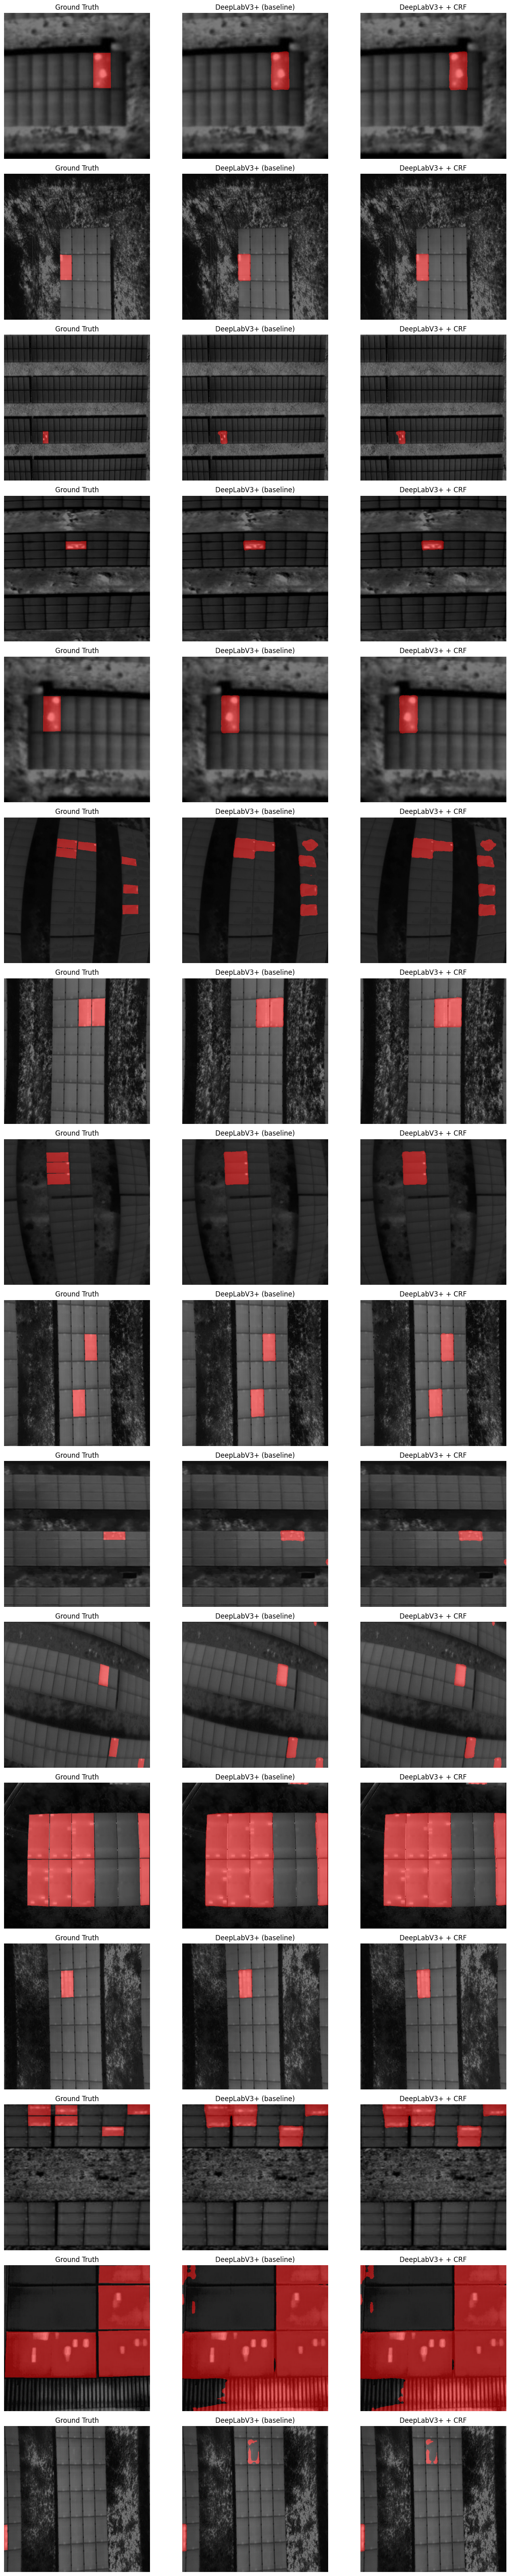

Saved random comparison visualization to /kaggle/working/output_seg/comparison_samples_random.png


In [17]:

import random

# -------------------------------
# Comparison visualization (GT | baseline | CRF) — RANDOM SAMPLING
# -------------------------------
N_samples = min(16, len(all_masks))   # show up to 16
indices = random.sample(range(len(all_masks)), N_samples)

fig, axes = plt.subplots(N_samples, 3, figsize=(14, 4*N_samples))

for row, idx in enumerate(indices):
    img_path, _ = valid_pairs[idx]
    img = np.array(Image.open(img_path).convert("L"))
    img_rgb = np.stack([img]*3, axis=-1).astype(np.uint8)

    axes[row, 0].imshow(overlay_image(img_rgb, colorize_mask(all_masks[idx])))
    axes[row, 0].set_title("Ground Truth")

    axes[row, 1].imshow(overlay_image(img_rgb, colorize_mask(all_preds_baseline[idx])))
    axes[row, 1].set_title("DeepLabV3+ (baseline)")

    axes[row, 2].imshow(overlay_image(img_rgb, colorize_mask(all_preds_crf[idx])))
    axes[row, 2].set_title("DeepLabV3+ + CRF")

    for col in range(3):
        axes[row, col].axis('off')

plt.tight_layout()

comparison_path = os.path.join(OUT_DIR, "comparison_samples_random.png")
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()

print("Saved random comparison visualization to", comparison_path)


**Training & Validation curves**

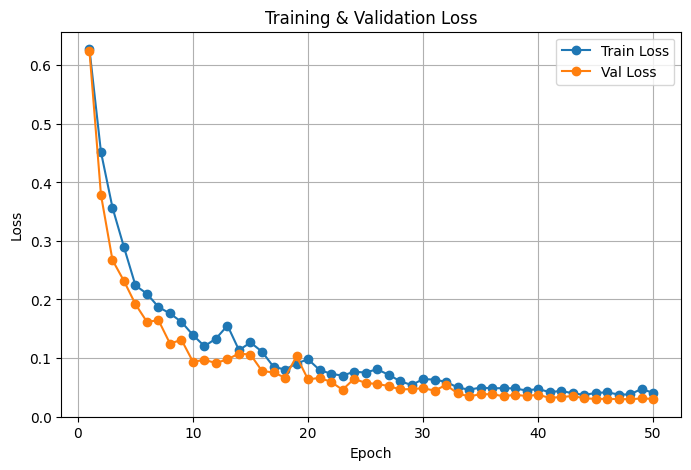

Saved loss curve to /kaggle/working/output_seg/loss_curve.png


In [18]:
# -------------------------------
# Training & Validation curves
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
loss_curve_path = os.path.join(OUT_DIR, "loss_curve.png")
plt.savefig(loss_curve_path, dpi=150, bbox_inches='tight')
plt.show()
print("Saved loss curve to", loss_curve_path)


**ROC & AUC (class 1)**

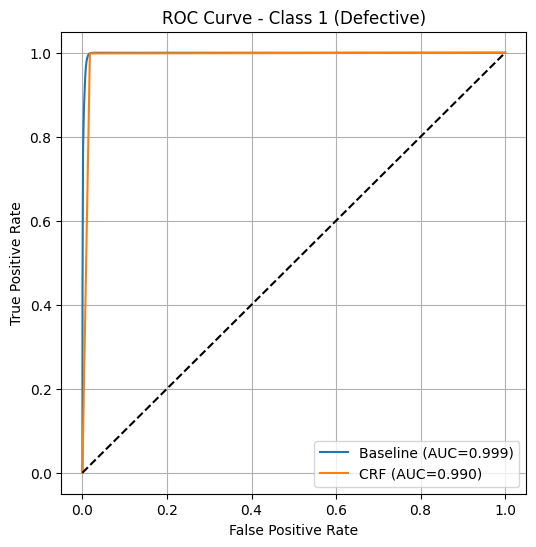

Saved ROC/AUC plot to /kaggle/working/output_seg/roc_auc.png


In [19]:
# -------------------------------
# ROC & AUC (class 1)
# -------------------------------
# For baseline: use class1 probabilities (continuous). For CRF: use binary map as scores (0/1).
masks_bin = (all_masks == 1).astype(np.uint8).flatten()
probs_baseline = all_probs_class1  # continuous scores
preds_crf_scores = (all_preds_crf == 1).astype(np.uint8).flatten()

# ROC for baseline (preferred)
fpr_base, tpr_base, _ = roc_curve(masks_bin, probs_baseline)
auc_base = auc(fpr_base, tpr_base)

# ROC for CRF (binary scores)
fpr_crf, tpr_crf, _ = roc_curve(masks_bin, preds_crf_scores)
auc_crf = auc(fpr_crf, tpr_crf)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_base:.3f})')
plt.plot(fpr_crf, tpr_crf, label=f'CRF (AUC={auc_crf:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Class 1 (Defective)')
plt.legend()
plt.grid(True)
roc_path = os.path.join(OUT_DIR, "roc_auc.png")
plt.savefig(roc_path, dpi=150, bbox_inches='tight')
plt.show()
print("Saved ROC/AUC plot to", roc_path)


In [20]:
# -------------------------------
# Per-image metrics and summary table
# -------------------------------
per_image_metrics = []
for i in range(len(all_masks)):
    mask_i = all_masks[i].flatten()
    pred_base_i = all_preds_baseline[i].flatten()
    pred_crf_i = all_preds_crf[i].flatten()

    # per-image macro metrics (zero_division=0 to be safe)
    f1_base = f1_score(mask_i, pred_base_i, average='macro', zero_division=0)
    f1_crf  = f1_score(mask_i, pred_crf_i, average='macro', zero_division=0)
    prec_base = precision_score(mask_i, pred_base_i, average='macro', zero_division=0)
    prec_crf  = precision_score(mask_i, pred_crf_i, average='macro', zero_division=0)
    rec_base = recall_score(mask_i, pred_base_i, average='macro', zero_division=0)
    rec_crf  = recall_score(mask_i, pred_crf_i, average='macro', zero_division=0)

    per_image_metrics.append({
        'image_idx': i,
        'f1_base': f1_base,
        'f1_crf': f1_crf,
        'precision_base': prec_base,
        'precision_crf': prec_crf,
        'recall_base': rec_base,
        'recall_crf': rec_crf
    })

df_metrics = pd.DataFrame(per_image_metrics)
metrics_table_path = os.path.join(OUT_DIR, "per_image_metrics.csv")
df_metrics.to_csv(metrics_table_path, index=False)
print("Saved per-image metrics CSV to", metrics_table_path)


Saved per-image metrics CSV to /kaggle/working/output_seg/per_image_metrics.csv


**Side-by-side overall metrics table**

In [21]:
# -------------------------------
# Side-by-side overall metrics table
# -------------------------------
metrics_names = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'mIoU']
metrics_summary = []
for name in metrics_names:
    metrics_summary.append({
        'metric': name,
        'baseline': metrics_baseline[name],
        'crf': metrics_crf[name]
    })
df_summary = pd.DataFrame(metrics_summary)
summary_csv = os.path.join(OUT_DIR, "metrics_summary.csv")
df_summary.to_csv(summary_csv, index=False)
print("Saved overall metrics summary CSV to", summary_csv)

# Pretty-print
print("\nMetrics comparison (Baseline vs CRF):")
for row in metrics_summary:
    print(f"{row['metric']:12}: Baseline={row['baseline']:.4f}, CRF={row['crf']:.4f}")

print("\nPer-class IoU comparison:")
for c in range(NUM_CLASSES):
    print(f"Class {c}: Baseline={metrics_baseline['ious'][c]:.4f}, CRF={metrics_crf['ious'][c]:.4f}")


Saved overall metrics summary CSV to /kaggle/working/output_seg/metrics_summary.csv

Metrics comparison (Baseline vs CRF):
accuracy    : Baseline=0.9832, CRF=0.9834
precision_macro: Baseline=0.9014, CRF=0.9023
recall_macro: Baseline=0.9903, CRF=0.9903
f1_macro    : Baseline=0.9405, CRF=0.9411
mIoU        : Baseline=0.8919, CRF=0.8929

Per-class IoU comparison:
Class 0: Baseline=0.9820, CRF=0.9822
Class 1: Baseline=0.8019, CRF=0.8037
